In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-cyclic Stocks

### Kweichow Moutai Co., Ltd.

In [6]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


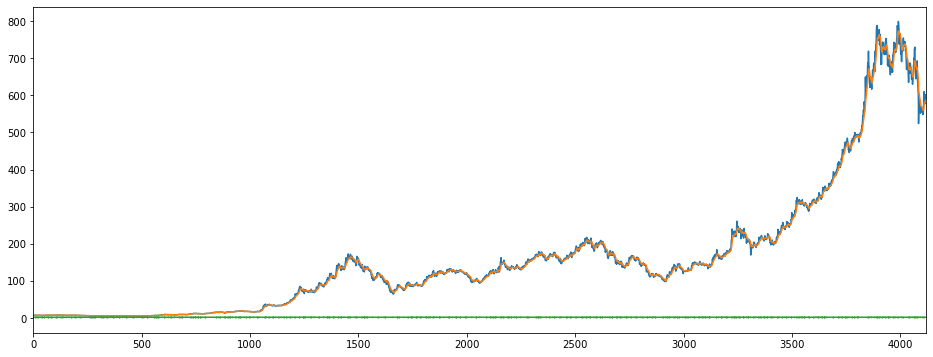

In [7]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [8]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2001-09-14,7.142585,7.257483,-41.873824,204624213.0,2.0
2001-09-17,7.224180,7.252359,-51.296847,208479649.0,2.0
2001-09-18,7.132634,7.233940,-72.964156,203965392.0,2.0
2001-09-19,7.214230,7.230908,-59.609037,209378730.0,2.0
2001-09-20,7.347568,7.248855,-37.785092,213725440.0,2.0


In [9]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [10]:
willr_data = np.array(willr_data)
willr_data.shape

(4111, 10, 1)

In [11]:
price_data = np.array(price_data)
price_data.shape

(4111, 10, 1)

In [12]:
ema_data = np.array(ema_data)
ema_data.shape

(4111, 10, 1)

In [13]:
obv_data = np.array(obv_data)
obv_data.shape

(4111, 10, 1)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [15]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4111, 64, 64, 1)

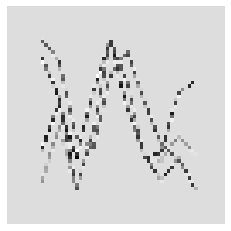

In [16]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [17]:
X = X/255

In [18]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [19]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [20]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [22]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.355704697986577, 1: 7.506849315068493, 2: 0.36618777146675574}
Epoch 1/200
 1/26 [>.............................] - ETA: 0s - loss: 0.6067 - accuracy: 0.6328 - mse: 5.6035 - weighted_accuracy: 0.2402 - weighted_mse: 6.4012WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 23ms/step - loss: 0.2540 - accuracy: 0.3811 - mse: 1.6970 - weighted_accuracy: 0.3136 - weighted_mse: 1.8057 - val_loss: 0.2161 - val_accuracy: 0.0486 - val_mse: 0.8593 - val_weighted_accuracy: 0.0486 - val_weighted_mse: 0.8593
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2096 - accuracy: 0.2929 - mse: 1.2135 - weighted_accuracy: 0.3072 - weighted_mse: 1.2098 - val_loss: 0.2139 - val_accuracy: 0.0462 - va

Epoch 27/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1881 - accuracy: 0.2701 - mse: 1.2937 - weighted_accuracy: 0.4817 - weighted_mse: 1.2633 - val_loss: 0.1928 - val_accuracy: 0.0693 - val_mse: 1.1000 - val_weighted_accuracy: 0.0693 - val_weighted_mse: 1.1000
Epoch 28/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1850 - accuracy: 0.2722 - mse: 1.3003 - weighted_accuracy: 0.4867 - weighted_mse: 1.2728 - val_loss: 0.1952 - val_accuracy: 0.0863 - val_mse: 1.0239 - val_weighted_accuracy: 0.0863 - val_weighted_mse: 1.0239
Epoch 29/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1818 - accuracy: 0.2530 - mse: 1.3252 - weighted_accuracy: 0.4990 - weighted_mse: 1.3041 - val_loss: 0.1934 - val_accuracy: 0.0778 - val_mse: 1.1307 - val_weighted_accuracy: 0.0778 - val_weighted_mse: 1.1307
Epoch 30/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1848 - accuracy: 0.2324 - mse: 1.3661 - weighted_accuracy: 0.4639 - weig

Epoch 56/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1663 - accuracy: 0.1959 - mse: 1.4701 - weighted_accuracy: 0.5859 - weighted_mse: 1.4282 - val_loss: 0.2015 - val_accuracy: 0.1300 - val_mse: 1.3161 - val_weighted_accuracy: 0.1300 - val_weighted_mse: 1.3161
Epoch 57/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1680 - accuracy: 0.1889 - mse: 1.4865 - weighted_accuracy: 0.5723 - weighted_mse: 1.4191 - val_loss: 0.2045 - val_accuracy: 0.1227 - val_mse: 1.2896 - val_weighted_accuracy: 0.1227 - val_weighted_mse: 1.2896
Epoch 58/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1644 - accuracy: 0.1959 - mse: 1.4484 - weighted_accuracy: 0.5707 - weighted_mse: 1.4287 - val_loss: 0.2036 - val_accuracy: 0.1142 - val_mse: 1.2616 - val_weighted_accuracy: 0.1142 - val_weighted_mse: 1.2616
Epoch 59/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1620 - accuracy: 0.1998 - mse: 1.5733 - weighted_accuracy: 0.5829 - weig

Epoch 113/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1251 - accuracy: 0.4571 - mse: 1.9451 - weighted_accuracy: 0.7370 - weighted_mse: 2.1114 - val_loss: 0.1751 - val_accuracy: 0.4593 - val_mse: 1.6180 - val_weighted_accuracy: 0.4593 - val_weighted_mse: 1.6180
Epoch 114/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1264 - accuracy: 0.4486 - mse: 1.9126 - weighted_accuracy: 0.7340 - weighted_mse: 2.1012 - val_loss: 0.1696 - val_accuracy: 0.4970 - val_mse: 1.6966 - val_weighted_accuracy: 0.4970 - val_weighted_mse: 1.6966
Epoch 115/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1234 - accuracy: 0.4827 - mse: 1.9821 - weighted_accuracy: 0.7487 - weighted_mse: 2.1877 - val_loss: 0.1757 - val_accuracy: 0.4666 - val_mse: 1.6606 - val_weighted_accuracy: 0.4666 - val_weighted_mse: 1.6606
Epoch 116/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1235 - accuracy: 0.4751 - mse: 1.9277 - weighted_accuracy: 0.7459 - 

Epoch 142/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1058 - accuracy: 0.6055 - mse: 2.3795 - weighted_accuracy: 0.7954 - weighted_mse: 2.9168 - val_loss: 0.1400 - val_accuracy: 0.6634 - val_mse: 2.0778 - val_weighted_accuracy: 0.6634 - val_weighted_mse: 2.0778
Epoch 143/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1039 - accuracy: 0.5982 - mse: 2.3289 - weighted_accuracy: 0.8100 - weighted_mse: 2.8050 - val_loss: 0.1399 - val_accuracy: 0.6671 - val_mse: 1.9012 - val_weighted_accuracy: 0.6671 - val_weighted_mse: 1.9012
Epoch 144/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1001 - accuracy: 0.5979 - mse: 2.3639 - weighted_accuracy: 0.8143 - weighted_mse: 2.9150 - val_loss: 0.1496 - val_accuracy: 0.6343 - val_mse: 2.0791 - val_weighted_accuracy: 0.6343 - val_weighted_mse: 2.0791
Epoch 145/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1043 - accuracy: 0.5973 - mse: 2.3701 - weighted_accuracy: 0.7860 - 

Epoch 171/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0895 - accuracy: 0.6855 - mse: 3.0234 - weighted_accuracy: 0.8291 - weighted_mse: 3.8897 - val_loss: 0.1187 - val_accuracy: 0.7424 - val_mse: 2.5606 - val_weighted_accuracy: 0.7424 - val_weighted_mse: 2.5606
Epoch 172/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0833 - accuracy: 0.7105 - mse: 2.9536 - weighted_accuracy: 0.8617 - weighted_mse: 3.8709 - val_loss: 0.1360 - val_accuracy: 0.6829 - val_mse: 2.3386 - val_weighted_accuracy: 0.6829 - val_weighted_mse: 2.3386
Epoch 173/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0861 - accuracy: 0.7074 - mse: 3.0900 - weighted_accuracy: 0.8521 - weighted_mse: 3.8374 - val_loss: 0.1274 - val_accuracy: 0.7157 - val_mse: 2.4462 - val_weighted_accuracy: 0.7157 - val_weighted_mse: 2.4462
Epoch 174/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0837 - accuracy: 0.6919 - mse: 3.0511 - weighted_accuracy: 0.8529 - 

Epoch 200/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0708 - accuracy: 0.7704 - mse: 3.9137 - weighted_accuracy: 0.8773 - weighted_mse: 5.0945 - val_loss: 0.1190 - val_accuracy: 0.7570 - val_mse: 3.0533 - val_weighted_accuracy: 0.7570 - val_weighted_mse: 3.0533


In [23]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1189902052283287
Test accuracy: 0.7569866180419922


In [24]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.6709973  -2.0982978   0.65619373]
 [-1.3434612  -1.4707552  -0.28502965]
 [-2.245267   -0.8965742   0.04216671]
 ...
 [-1.8747337  -2.7056484   0.99760044]
 [-1.4649462  -2.2609775   0.72154325]
 [-0.80262387 -2.4982996   0.09183092]]


Counter({2: 661, 1: 116, 0: 46})

In [25]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 749, 1: 37, 0: 37})

In [26]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 823
actual predicted buys: 12
actual buys but predicted sell: 0
actual buys but predicted hold: 25
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 30
actual holds but predicted buy: 102
actual holds but predicted sell: 41
actual predicted holds: 606
Percentage buys correct: 32.432432432432435%
Percentage sells correct: 13.513513513513514%
Percentage holds correct: 80.90787716955941%
actual buys: 37
actual sells: 37
actual holds: 749


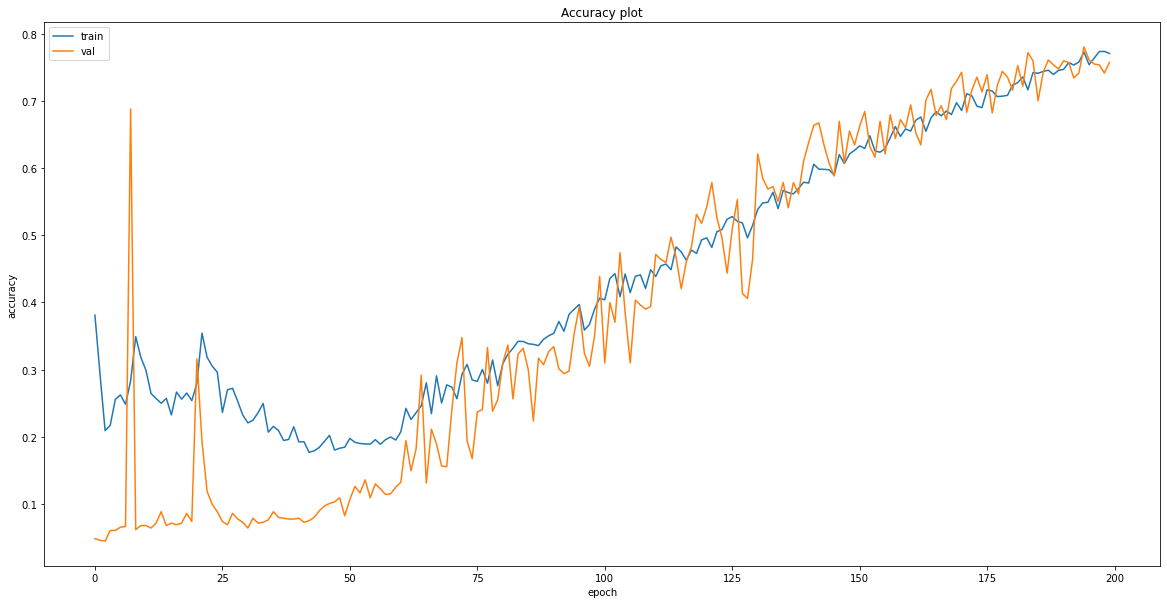

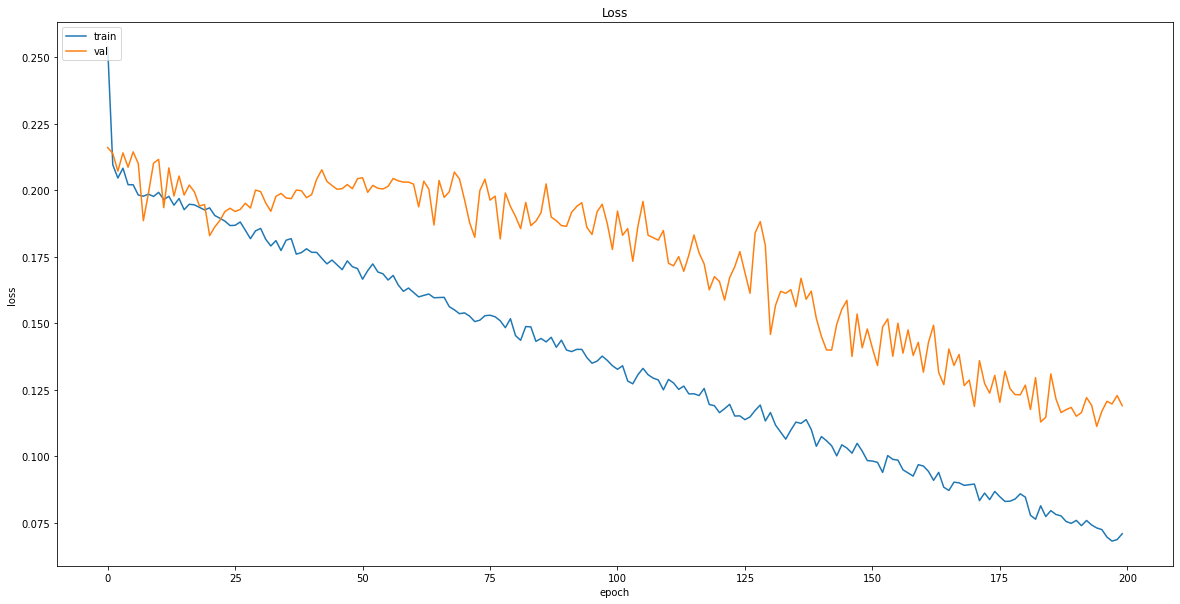

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
# Save model
model.save("models/{}".format('moutai_image_cnn_buy_hold_sell_10.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_image_cnn_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [29]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-29   677.000000  659.619507 -24.354406  29659266.0     2.0
2019-01-30   685.000000  663.524198 -15.660616  32693525.0     2.0
2019-01-31   676.000000  665.443552 -28.553605  30423529.0     2.0
2019-02-01   689.599976  669.159925 -12.000552  34093186.0     2.0
2019-02-11   692.669983  672.776857  -8.554077  37145248.0     2.0


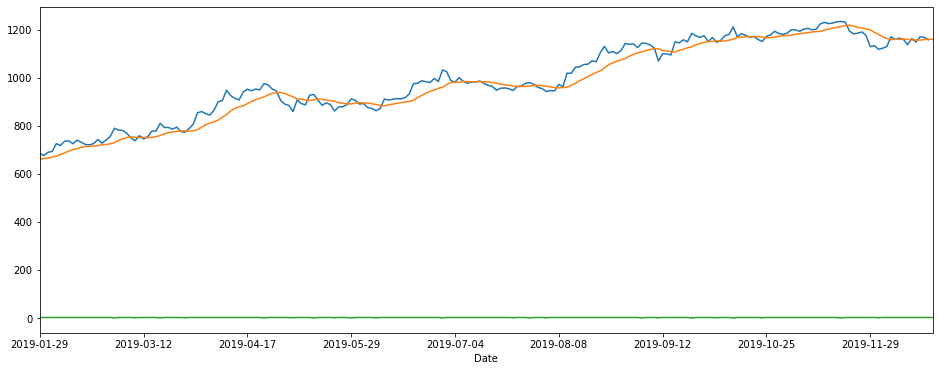

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [32]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [34]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [35]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [36]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1175 - accuracy: 0.7778 - mean_squared_error: 3.1046 - weighted_accuracy: 0.7778 - weighted_mean_squared_error: 3.1046
Test loss: 0.1175440326333046
Test accuracy: 0.7777777910232544


In [37]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 1: 27, 0: 9})

In [38]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [39]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,1,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,1,2


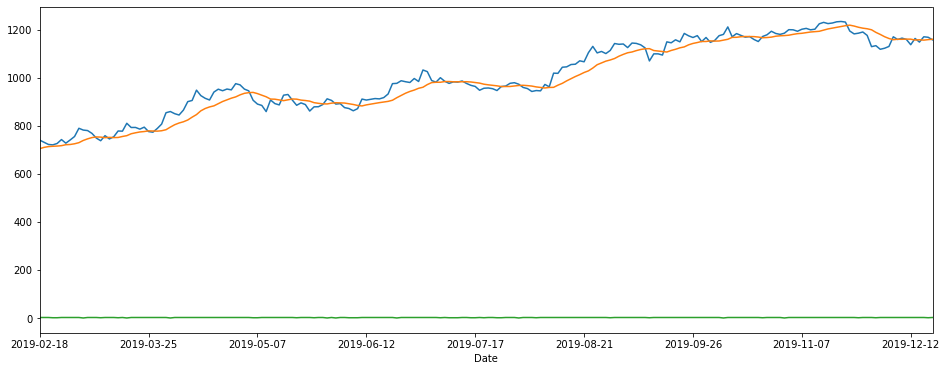

In [40]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

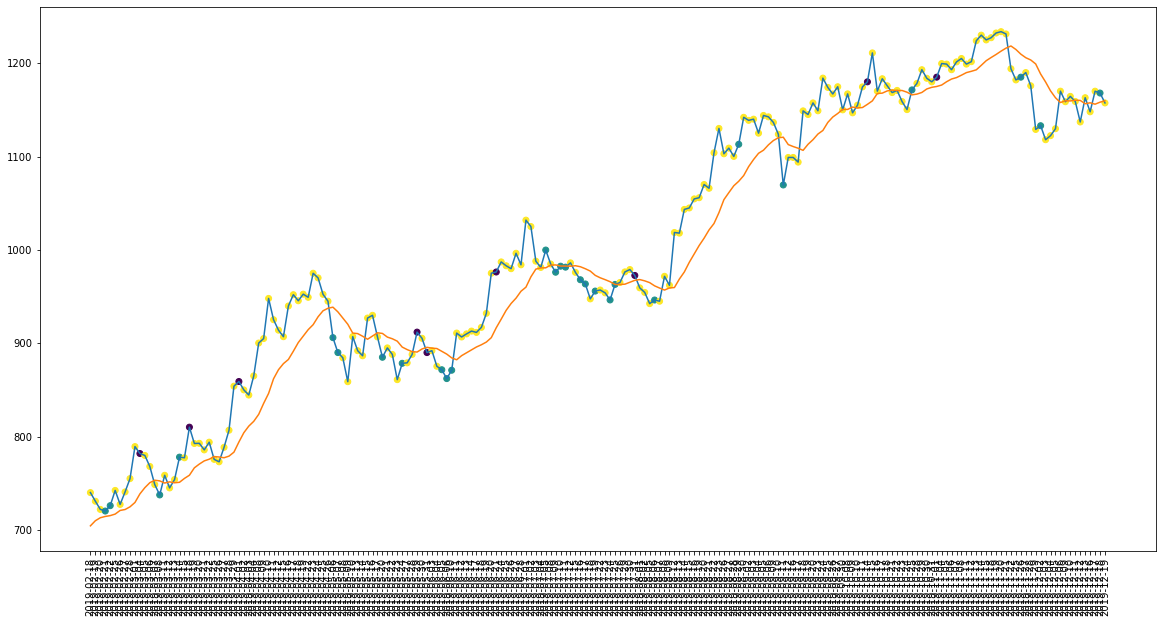

In [41]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

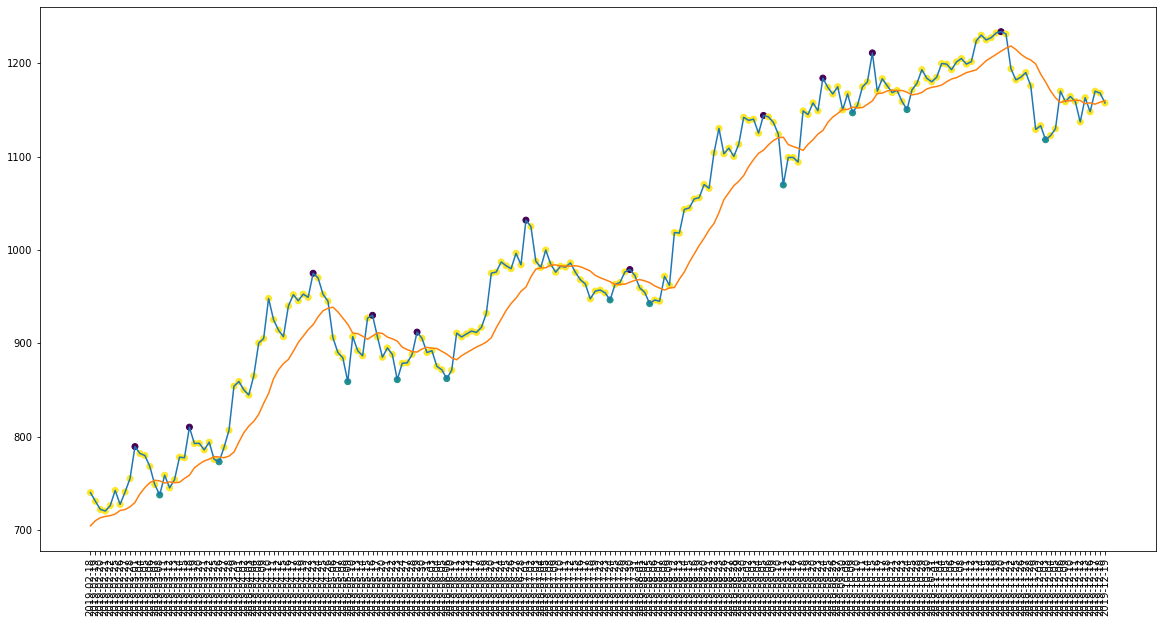

In [42]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [43]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 23
actual holds but predicted sell: 7
actual predicted holds: 155
Percentage buys correct: 36.36363636363637%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 83.78378378378379%
actual buys: 11
actual sells: 11
actual holds: 185


In [44]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 59.25925925925926%
Percentage sells correct: 77.77777777777777%
Percentage holds correct: 86.47058823529412%


In [45]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $720.25
Shares owned at the moment: 13
Cash capital at the moment: $611.0010624999995


Price increase from previously bought: 8.256267544926565%
Share price: $781.8599853515625
Shares owned at the moment: 0
Cash capital at the moment: $10747.229377593992


Share price: $737.5
Shares owned at the moment: 14
Cash capital at the moment: $393.8356275939914


Price increase from previously bought: 9.54147644560086%
Share price: $810.0900268554688
Shares owned at the moment: 0
Cash capital at the moment: $11703.907537536617


Share price: $906.0
Shares owned at the moment: 12
Cash capital at the moment: $802.0095375366163


Stop Loss Activated!

Share price: $858.8099975585938
Shares owned at the moment: 0
Cash capital at the moment: $11079.388778320308


Share price: $884.9600219726562
Shares owned at the moment: 12
Cash capital at the moment: $430.6648339233343


Price increase from previously bought: 10.018814598720137%
Share price: $976.2999877929688
Shares owned at the mom

In [46]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [47]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d       EMA_12   willr_14      OBV_7  labels
Date                                                              
2020-02-06   1049.98999  1066.271722 -51.486809 -1866021.0     2.0
2020-02-07   1071.00000  1066.999149 -36.923832  2851100.0     2.0
2020-02-10   1076.00000  1068.383896 -33.458108  5978971.0     2.0
2020-02-11   1066.48999  1068.092525 -38.919488  2925629.0     2.0
2020-02-12   1098.00000  1072.693675 -16.666652  7717422.0     2.0


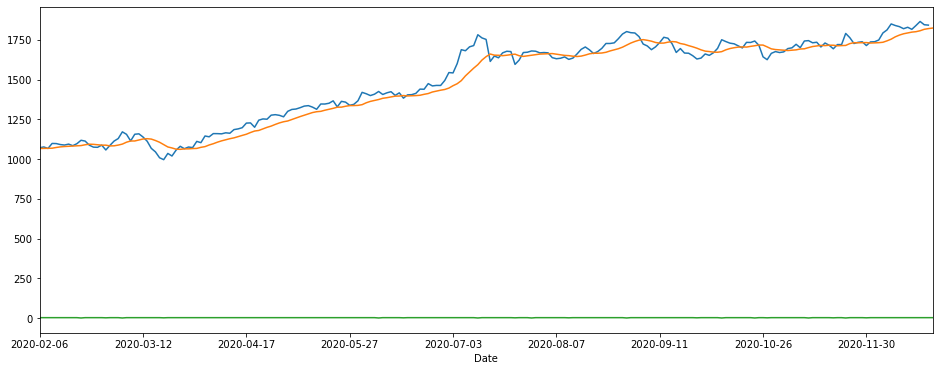

In [48]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [49]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [50]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [52]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [53]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [54]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1108 - accuracy: 0.7933 - mean_squared_error: 2.9630 - weighted_accuracy: 0.7933 - weighted_mean_squared_error: 2.9630
Test loss: 0.11084314435720444
Test accuracy: 0.7932692170143127


In [55]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 1: 17, 0: 11})

In [56]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [57]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


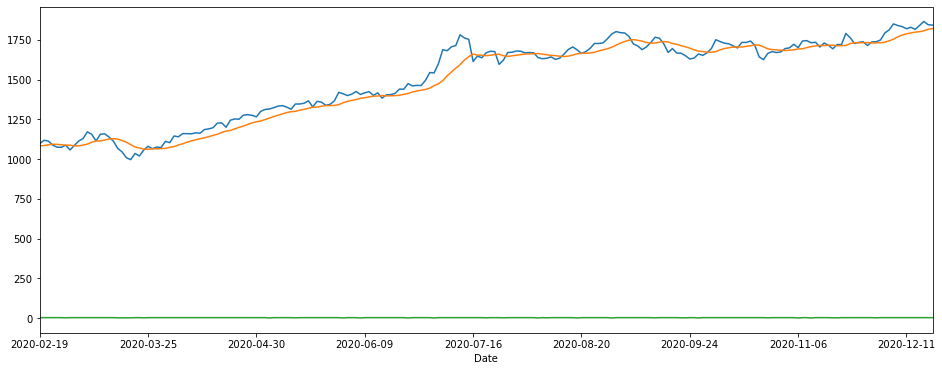

In [58]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

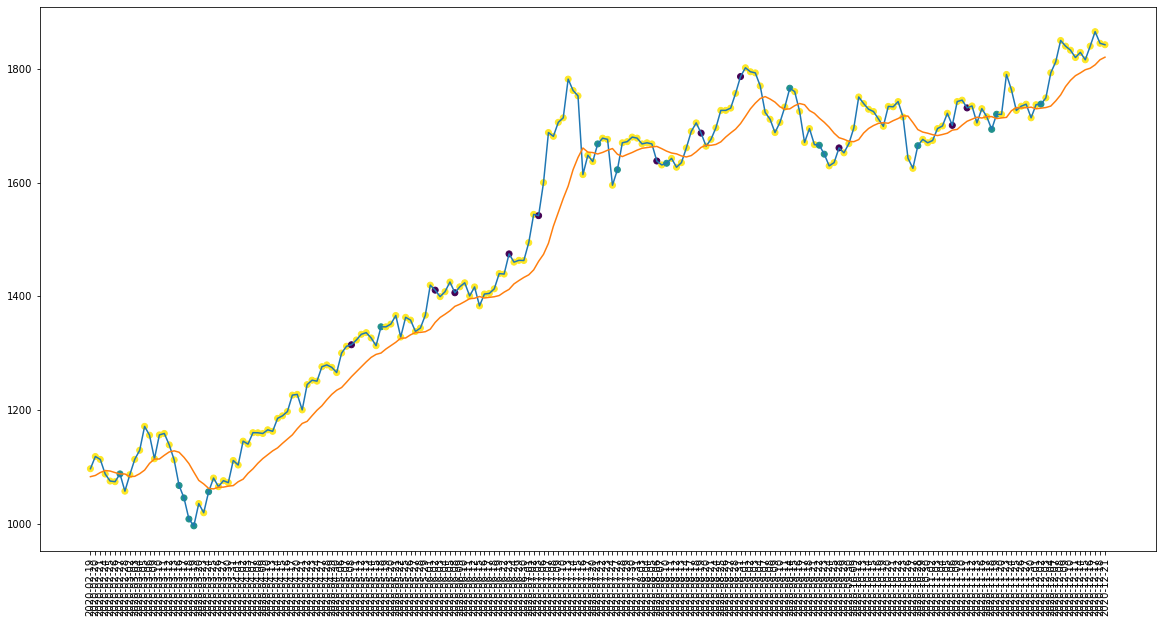

In [59]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

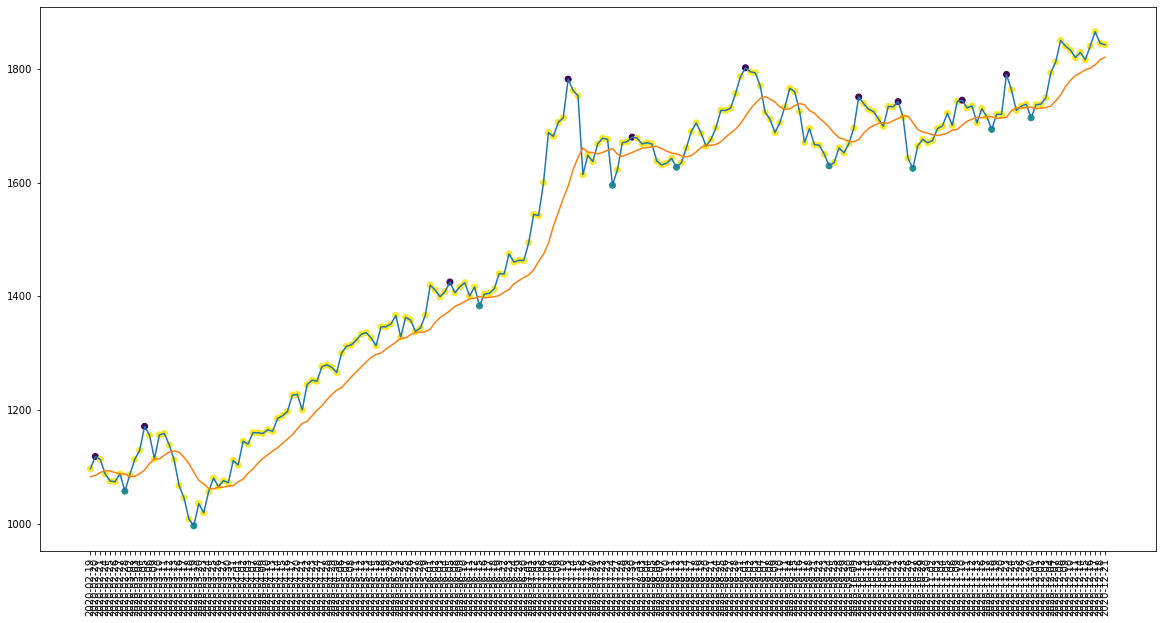

In [60]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [61]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 15
actual holds but predicted sell: 11
actual predicted holds: 163
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 0.0%
Percentage holds correct: 86.24338624338624%
actual buys: 9
actual sells: 10
actual holds: 189


In [62]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 41.1764705882353%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 84.35754189944134%


In [63]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1087.3900146484377
Shares owned at the moment: 9
Cash capital at the moment: $186.57696530151225


Stop Loss Activated!

Share price: $1057.0
Shares owned at the moment: 0
Cash capital at the moment: $9673.416215301511


Share price: $1067.0
Shares owned at the moment: 9
Cash capital at the moment: $44.00796530151092


Stop Loss Activated!

Share price: $1007.989990234375
Shares owned at the moment: 0
Cash capital at the moment: $9090.970125152586


Share price: $1007.989990234375
Shares owned at the moment: 8
Cash capital at the moment: $1004.8744234924288


Price increase from previously bought: 30.06128384868458%
Share price: $1314.6099853515625
Shares owned at the moment: 0
Cash capital at the moment: $11492.832886627195


Share price: $1346.2099609375
Shares owned at the moment: 8
Cash capital at the moment: $693.5365799865704


Price increase from previously bought: 9.229339255618818%
Share price: $1474.5
Shares owned at the moment: 0
Cash capital at the moment: $12

In [64]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

In [65]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


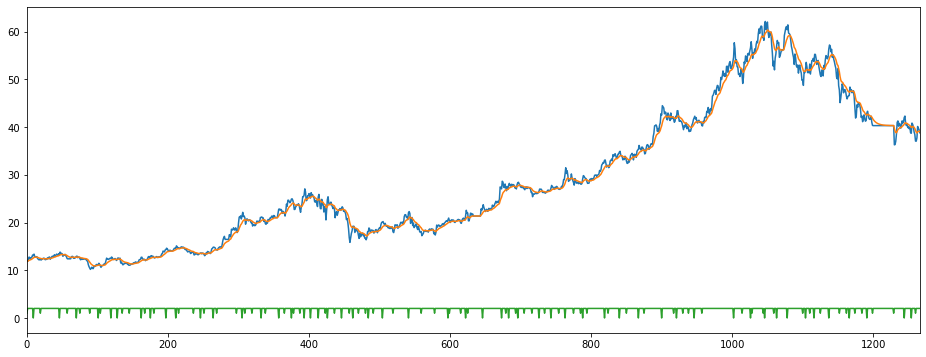

In [66]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [67]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [68]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [69]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [70]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [72]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(1258, 64, 64, 1)

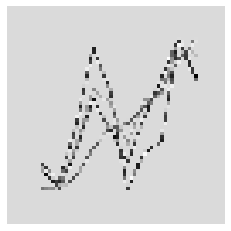

In [73]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [74]:
X = X/255

In [75]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [76]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [77]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [79]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.984126984126984, 1: 6.706666666666667, 2: 0.36688548504741064}
Epoch 1/200
8/8 [==============================] - 2s 270ms/step - loss: 0.3333 - accuracy: 0.4175 - mse: 2.8100 - weighted_accuracy: 0.3197 - weighted_mse: 3.0609 - val_loss: 0.1624 - val_accuracy: 0.9087 - val_mse: 0.8915 - val_weighted_accuracy: 0.9087 - val_weighted_mse: 0.8915
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2264 - accuracy: 0.4920 - mse: 1.2997 - weighted_accuracy: 0.3987 - weighted_mse: 1.3699 - val_loss: 0.1879 - val_accuracy: 0.7262 - val_mse: 0.8280 - val_weighted_accuracy: 0.7262 - val_weighted_mse: 0.8280
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2198 - accuracy: 0.2555 - mse: 1.2749 - weighted_accuracy: 0.3371 - weighted_mse: 1.2348 - val_loss: 0.2229 - val_accuracy: 0.0476 - val_mse: 1.0486 - val_weighted_accuracy: 0.0476 - val_weighted_mse: 1.0486
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2110 - acc

Epoch 29/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2017 - accuracy: 0.3986 - mse: 1.1852 - weighted_accuracy: 0.3606 - weighted_mse: 1.1691 - val_loss: 0.1818 - val_accuracy: 0.9048 - val_mse: 0.9302 - val_weighted_accuracy: 0.9048 - val_weighted_mse: 0.9302
Epoch 30/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2018 - accuracy: 0.4036 - mse: 1.1659 - weighted_accuracy: 0.3372 - weighted_mse: 1.1768 - val_loss: 0.1964 - val_accuracy: 0.0635 - val_mse: 1.0280 - val_weighted_accuracy: 0.0635 - val_weighted_mse: 1.0280
Epoch 31/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1984 - accuracy: 0.2843 - mse: 1.2428 - weighted_accuracy: 0.4183 - weighted_mse: 1.2011 - val_loss: 0.2030 - val_accuracy: 0.0595 - val_mse: 1.1190 - val_weighted_accuracy: 0.0595 - val_weighted_mse: 1.1190
Epoch 32/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2002 - accuracy: 0.3141 - mse: 1.1433 - weighted_accuracy: 0.3119 - weighted

Epoch 58/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1976 - accuracy: 0.2604 - mse: 1.1655 - weighted_accuracy: 0.4133 - weighted_mse: 1.1436 - val_loss: 0.1955 - val_accuracy: 0.1270 - val_mse: 1.0388 - val_weighted_accuracy: 0.1270 - val_weighted_mse: 1.0388
Epoch 59/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1924 - accuracy: 0.3300 - mse: 1.1733 - weighted_accuracy: 0.4868 - weighted_mse: 1.1753 - val_loss: 0.1872 - val_accuracy: 0.4643 - val_mse: 0.9547 - val_weighted_accuracy: 0.4643 - val_weighted_mse: 0.9547
Epoch 60/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1919 - accuracy: 0.3509 - mse: 1.2311 - weighted_accuracy: 0.3860 - weighted_mse: 1.2677 - val_loss: 0.1903 - val_accuracy: 0.3095 - val_mse: 0.9782 - val_weighted_accuracy: 0.3095 - val_weighted_mse: 0.9782
Epoch 61/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1938 - accuracy: 0.3459 - mse: 1.1178 - weighted_accuracy: 0.4106 - weighted

Epoch 87/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1825 - accuracy: 0.3847 - mse: 1.1903 - weighted_accuracy: 0.4576 - weighted_mse: 1.1764 - val_loss: 0.1861 - val_accuracy: 0.3492 - val_mse: 0.9976 - val_weighted_accuracy: 0.3492 - val_weighted_mse: 0.9976
Epoch 88/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1869 - accuracy: 0.3151 - mse: 1.2765 - weighted_accuracy: 0.4775 - weighted_mse: 1.2641 - val_loss: 0.1908 - val_accuracy: 0.1786 - val_mse: 1.0309 - val_weighted_accuracy: 0.1786 - val_weighted_mse: 1.0309
Epoch 89/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1837 - accuracy: 0.3698 - mse: 1.2154 - weighted_accuracy: 0.4787 - weighted_mse: 1.1872 - val_loss: 0.1820 - val_accuracy: 0.4802 - val_mse: 1.0247 - val_weighted_accuracy: 0.4802 - val_weighted_mse: 1.0247
Epoch 90/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1849 - accuracy: 0.3777 - mse: 1.2102 - weighted_accuracy: 0.4689 - weighted

Epoch 116/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1704 - accuracy: 0.2843 - mse: 1.3067 - weighted_accuracy: 0.5986 - weighted_mse: 1.2881 - val_loss: 0.1910 - val_accuracy: 0.2500 - val_mse: 0.9997 - val_weighted_accuracy: 0.2500 - val_weighted_mse: 0.9997
Epoch 117/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1717 - accuracy: 0.2952 - mse: 1.2982 - weighted_accuracy: 0.5800 - weighted_mse: 1.3072 - val_loss: 0.1830 - val_accuracy: 0.2619 - val_mse: 1.1073 - val_weighted_accuracy: 0.2619 - val_weighted_mse: 1.1073
Epoch 118/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1741 - accuracy: 0.2952 - mse: 1.2706 - weighted_accuracy: 0.5800 - weighted_mse: 1.2117 - val_loss: 0.1911 - val_accuracy: 0.2024 - val_mse: 1.0134 - val_weighted_accuracy: 0.2024 - val_weighted_mse: 1.0134
Epoch 119/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1763 - accuracy: 0.2614 - mse: 1.3133 - weighted_accuracy: 0.5171 - weig

Epoch 145/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1593 - accuracy: 0.3221 - mse: 1.3996 - weighted_accuracy: 0.6529 - weighted_mse: 1.3629 - val_loss: 0.1888 - val_accuracy: 0.2421 - val_mse: 1.0920 - val_weighted_accuracy: 0.2421 - val_weighted_mse: 1.0920
Epoch 146/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1653 - accuracy: 0.2922 - mse: 1.4332 - weighted_accuracy: 0.5663 - weighted_mse: 1.4528 - val_loss: 0.1774 - val_accuracy: 0.3452 - val_mse: 1.1169 - val_weighted_accuracy: 0.3452 - val_weighted_mse: 1.1169
Epoch 147/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1618 - accuracy: 0.3320 - mse: 1.3844 - weighted_accuracy: 0.6427 - weighted_mse: 1.3642 - val_loss: 0.1904 - val_accuracy: 0.2262 - val_mse: 1.0918 - val_weighted_accuracy: 0.2262 - val_weighted_mse: 1.0918
Epoch 148/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1623 - accuracy: 0.3201 - mse: 1.3735 - weighted_accuracy: 0.6219 - weig

Epoch 174/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1470 - accuracy: 0.3559 - mse: 1.6807 - weighted_accuracy: 0.6993 - weighted_mse: 1.6972 - val_loss: 0.1837 - val_accuracy: 0.3175 - val_mse: 1.2817 - val_weighted_accuracy: 0.3175 - val_weighted_mse: 1.2817
Epoch 175/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1493 - accuracy: 0.3549 - mse: 1.5043 - weighted_accuracy: 0.6712 - weighted_mse: 1.5474 - val_loss: 0.1860 - val_accuracy: 0.3214 - val_mse: 1.0895 - val_weighted_accuracy: 0.3214 - val_weighted_mse: 1.0895
Epoch 176/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1512 - accuracy: 0.3628 - mse: 1.4542 - weighted_accuracy: 0.6401 - weighted_mse: 1.5083 - val_loss: 0.1773 - val_accuracy: 0.3810 - val_mse: 1.2533 - val_weighted_accuracy: 0.3810 - val_weighted_mse: 1.2533
Epoch 177/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1462 - accuracy: 0.3598 - mse: 1.6243 - weighted_accuracy: 0.6756 - weig

In [80]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18199551105499268
Test accuracy: 0.380952388048172


In [81]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.25823984 -1.6265621  -0.6643808 ]
 [-0.16920298 -0.8184736  -0.4295811 ]
 [-1.5893391  -0.2221761  -0.5872393 ]
 [-0.4494727  -0.9469347  -0.32611457]
 [-0.27732477 -1.6502768  -0.6062401 ]
 [-1.4337794  -0.27198783 -0.50629276]
 [-1.1956939  -0.32143554 -0.44493812]
 [-1.5876416  -0.04517798 -0.60134375]
 [-0.24341261 -0.9814789  -0.30230287]
 [-1.5101687  -0.23118134 -0.51947594]
 [-1.1489007  -0.389228   -0.40416104]
 [-1.8121188  -0.20892969 -0.670397  ]
 [-0.12794149 -1.3154578  -0.61327386]
 [-1.2532915  -0.23451918 -0.4642701 ]
 [-0.17339936 -0.8364097  -0.4369714 ]
 [-0.28116834 -1.356904   -0.4112444 ]
 [-1.2733867  -0.32853338 -0.4407902 ]
 [-0.5017324  -0.90379035 -0.22232014]
 [-0.9638125  -0.46646434 -0.3956414 ]
 [-1.0117342  -0.5047206  -0.3420809 ]
 [-0.15786779 -0.91396284 -0.4871018 ]
 [-0.4146165  -1.3323025  -0.18003872]
 [-0.34161243 -0.85206044 -0.19457617]
 [-0.18989666 -1.0959966  -0.4095758 ]
 [-2.505709    0.13387744 -1.0034592 ]
 [-0.6168123  -0.64711595

Counter({0: 86, 1: 73, 2: 93})

In [82]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 229, 1: 12, 0: 11})

In [83]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 252
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 66
actual holds but predicted sell: 79
actual predicted holds: 84
Percentage buys correct: 50.0%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 36.68122270742358%
actual buys: 12
actual sells: 11
actual holds: 229


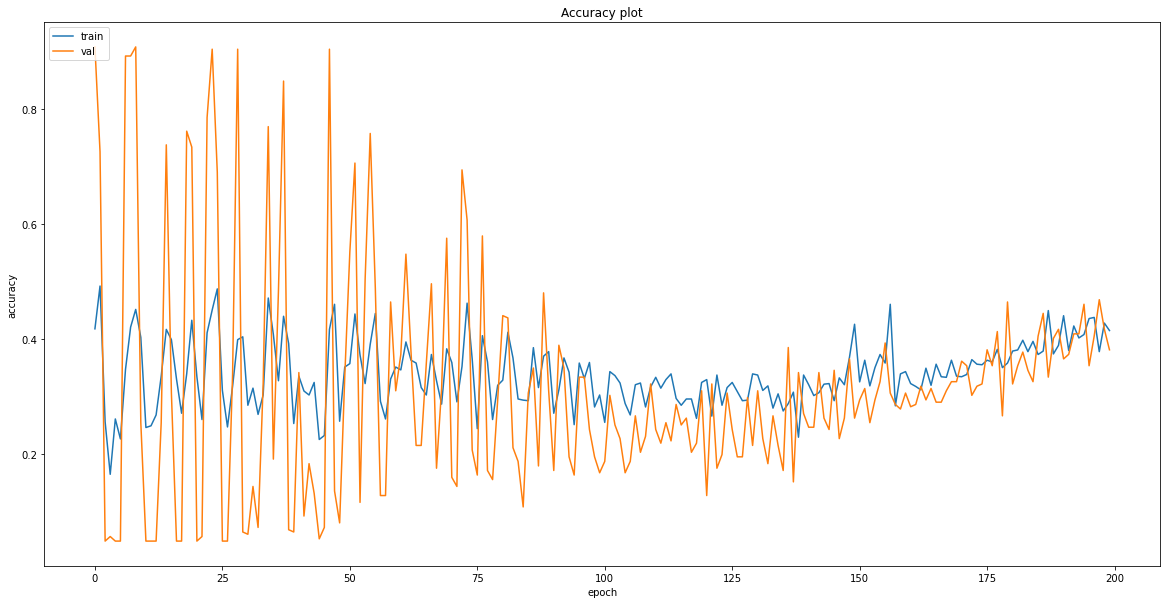

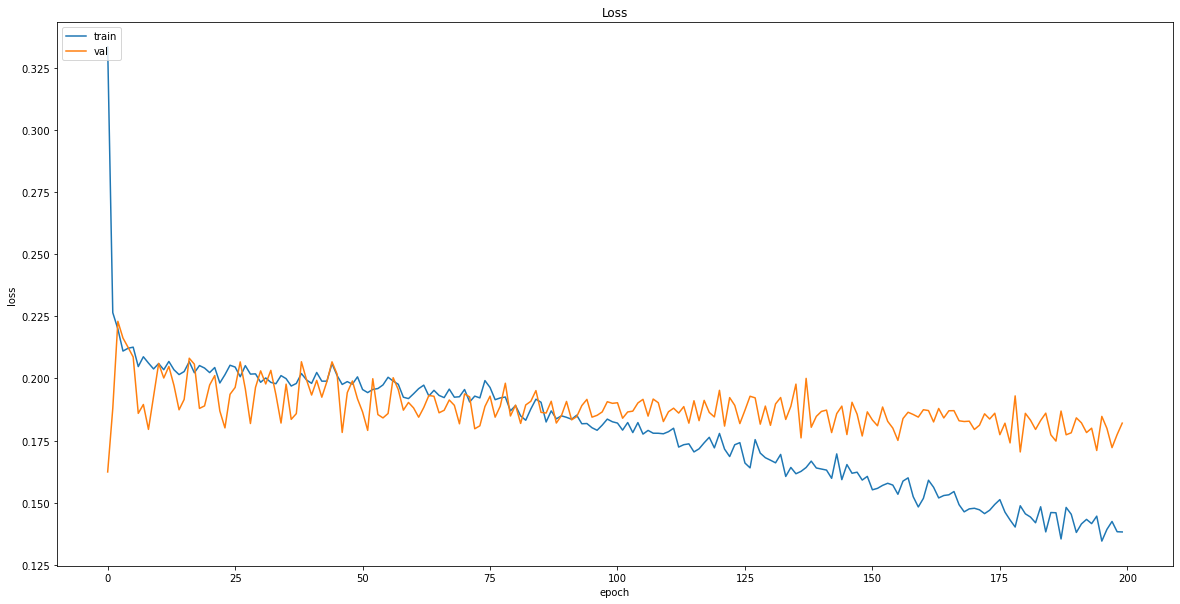

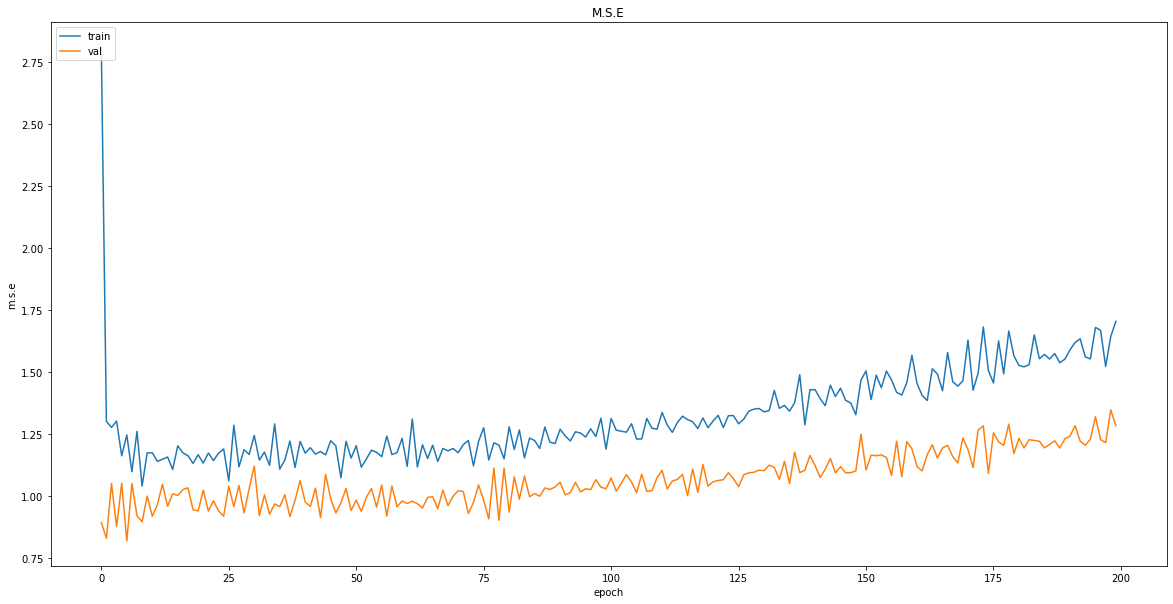

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [85]:
# Save model
model.save("models/{}".format('midea_image_cnn_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/midea_image_cnn_buy_hold_sell_10.model\assets


### Test Performance

#### Non-Recession

In [86]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-29    41.840000  40.791393 -22.393818  268032095.0     2.0
2019-01-30    43.000000  41.131179  -0.000000  305001247.0     2.0
2019-01-31    42.099998  41.280228 -21.686776  275782105.0     2.0
2019-02-01    43.529999  41.626347  -1.635507  314703641.0     2.0
2019-02-11    44.259998  42.031524  -4.642200  345923962.0     2.0


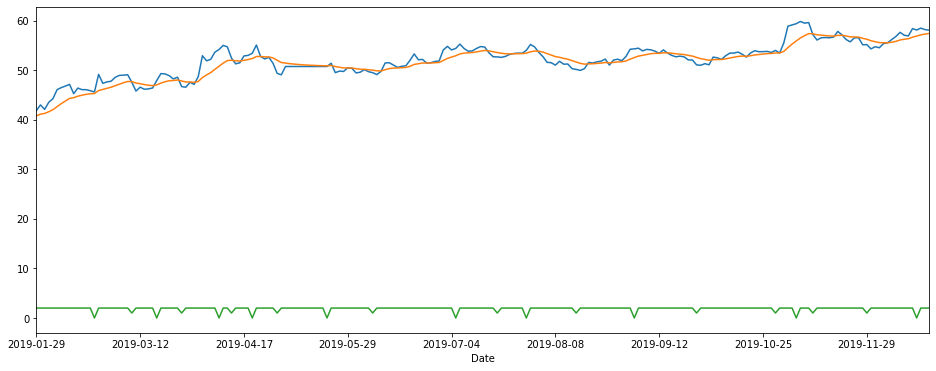

In [87]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [88]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [90]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [91]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [92]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1754 - accuracy: 0.4300 - mean_squared_error: 1.2742 - weighted_accuracy: 0.4300 - weighted_mean_squared_error: 1.2742
Test loss: 0.1754482239484787
Test accuracy: 0.4299516975879669


In [93]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 56, 2: 76, 0: 75})

In [94]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [95]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,1,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,1,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,1,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,1,2


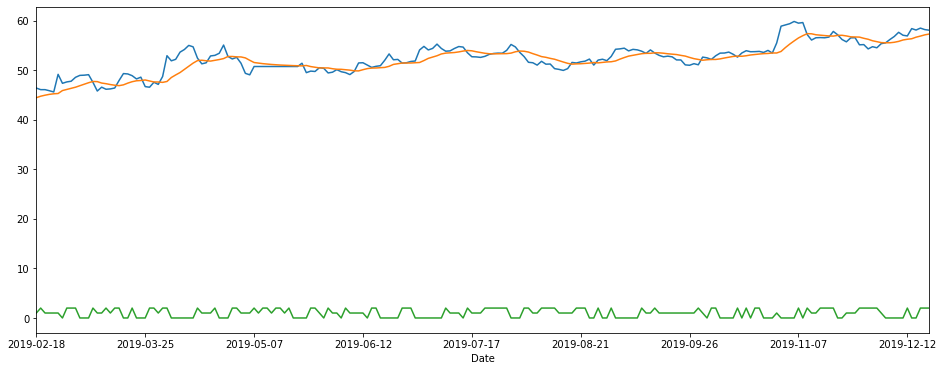

In [96]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

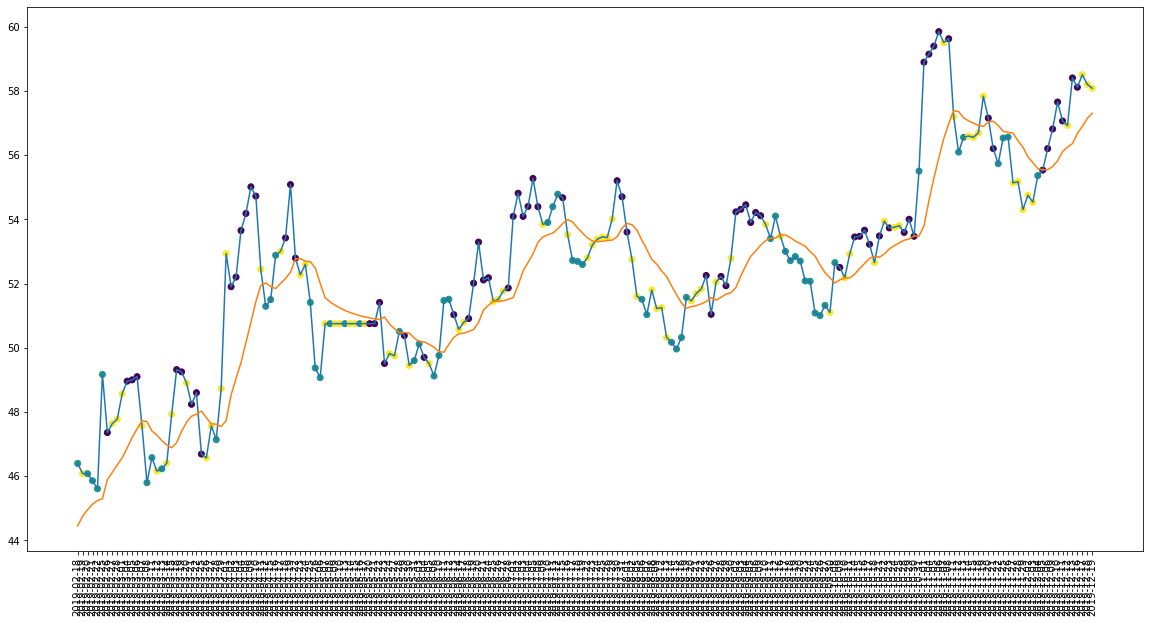

In [97]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

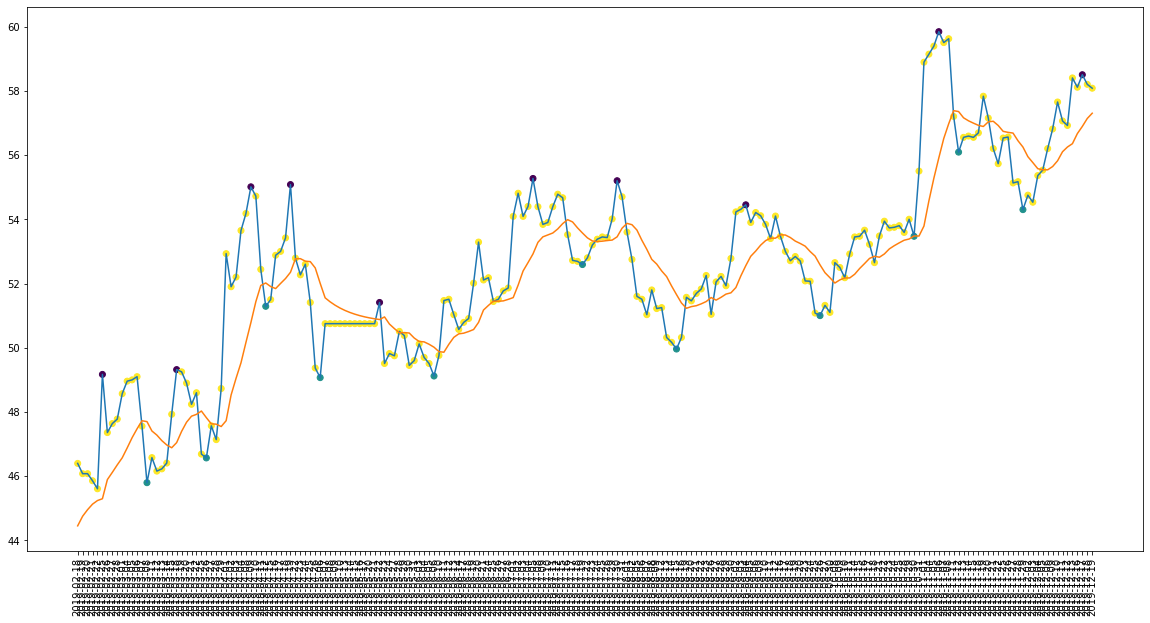

In [98]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [99]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 47
actual holds but predicted sell: 66
actual predicted holds: 73
Percentage buys correct: 72.72727272727273%
Percentage sells correct: 80.0%
Percentage holds correct: 39.24731182795699%
actual buys: 11
actual sells: 10
actual holds: 186


In [100]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 58.92857142857143%
Percentage sells correct: 61.333333333333336%
Percentage holds correct: 81.33333333333333%


In [101]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.4000015258789
Shares owned at the moment: 214
Cash capital at the moment: $43.0932725639359


Price increase from previously bought: 5.227859323084405%
Share price: $48.959999084472656
Shares owned at the moment: 0
Cash capital at the moment: $10491.720117179872


Share price: $45.79999923706055
Shares owned at the moment: 228
Cash capital at the moment: $20.60369160843038


Price increase from previously bought: 7.390267411779328%
Share price: $49.31999969482422
Shares owned at the moment: 0
Cash capital at the moment: $11234.639982219696


Share price: $47.13999938964844
Shares owned at the moment: 237
Cash capital at the moment: $31.73663227081306


Price increase from previously bought: 9.795648301200632%
Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $12298.21116790962


Share price: $51.290000915527344
Shares owned at the moment: 239
Cash capital at the moment: $6.190595996853517


Price increase from previously bought: 7

In [102]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


#### Recession

In [103]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df = df.iloc[5:]
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-02-06    52.869999  55.859049 -71.253297 -22831883.0     2.0
2020-02-07    53.790001  55.540734 -63.190177  16534916.0     2.0
2020-02-10    52.830002  55.123698 -71.603841 -17874085.0     2.0
2020-02-11    52.299999  54.689283 -76.248912 -52478854.0     2.0
2020-02-12    54.680000  54.687855 -55.390007  -3090621.0     0.0


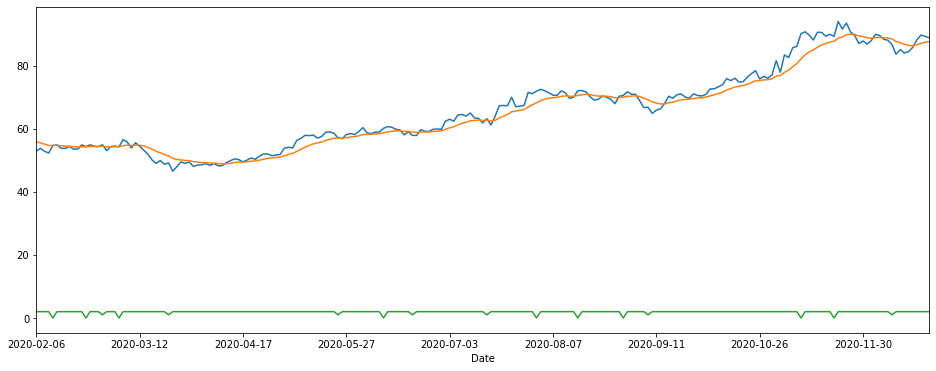

In [104]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [105]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [107]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [108]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [109]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.5000 - mean_squared_error: 1.2171 - weighted_accuracy: 0.5000 - weighted_mean_squared_error: 1.2171
Test loss: 0.1725311279296875
Test accuracy: 0.5


In [110]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 102, 0: 64, 1: 42})

In [111]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [112]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,0,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,0,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,2,2


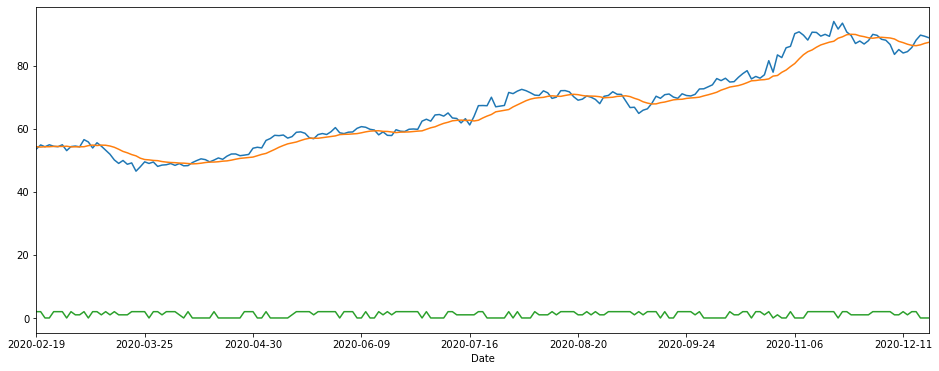

In [113]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

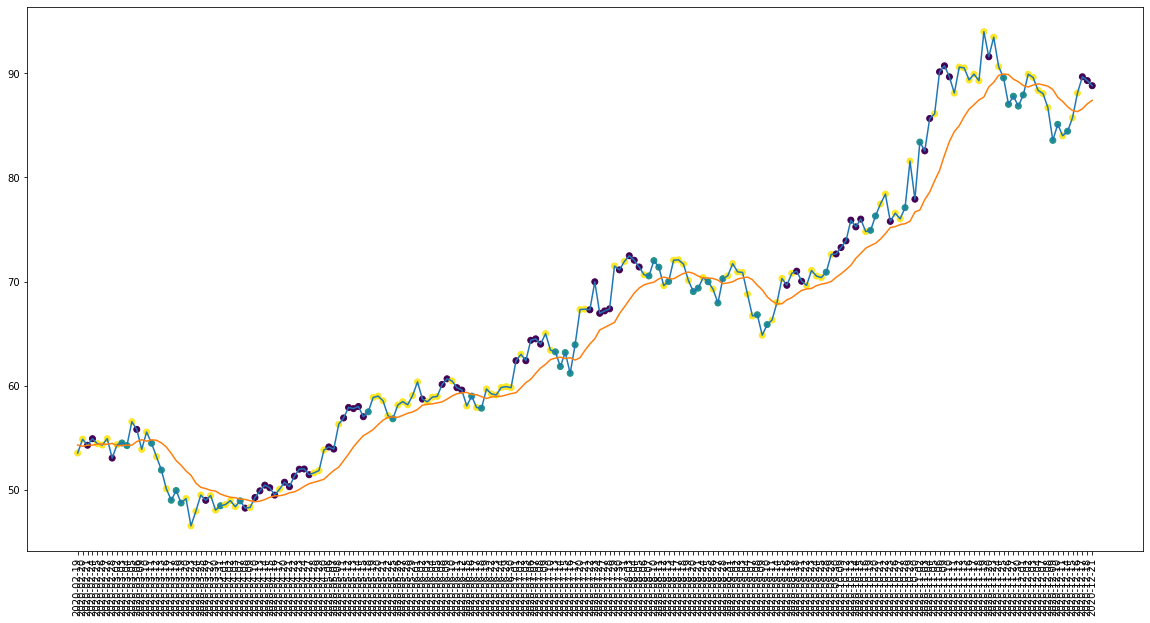

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

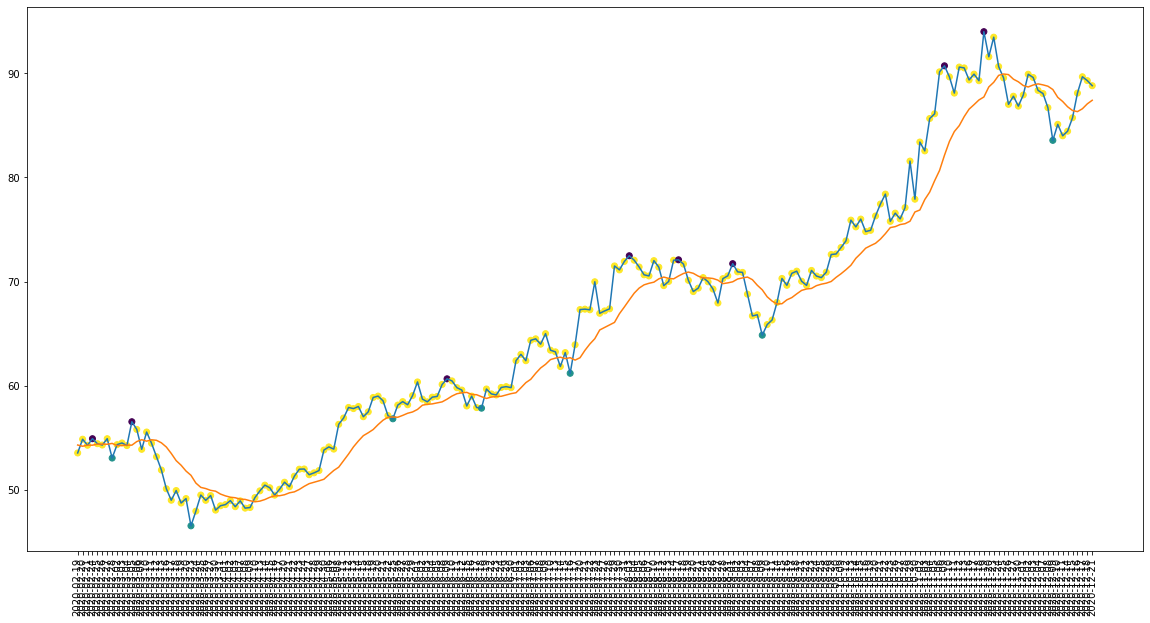

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 38
actual holds but predicted sell: 59
actual predicted holds: 96
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 50.0%
Percentage holds correct: 49.740932642487046%
actual buys: 7
actual sells: 8
actual holds: 193


In [117]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 69.04761904761905%
Percentage sells correct: 52.38095238095238%
Percentage holds correct: 84.31372549019608%


In [118]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.5
Shares owned at the moment: 182
Cash capital at the moment: $53.722749999998996


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9473.547076946255


Share price: $51.9000015258789
Shares owned at the moment: 182
Cash capital at the moment: $1.7708484725935705


Stop Loss Activated!

Share price: $50.099998474121094
Shares owned at the moment: 0
Cash capital at the moment: $9094.895521526334


Share price: $49.0
Shares owned at the moment: 185
Cash capital at the moment: $4.966771526333105


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8591.189715433116


Share price: $48.47000122070313
Shares owned at the moment: 176
Cash capital at the moment: $37.01001999854452


Price increase from previously bought: 5.568979881482927%
Share price: $51.31000137329102
Shares owned at the moment: 0
Cash capital at the moment: $9042.736221033092


Shar

In [119]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [120]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


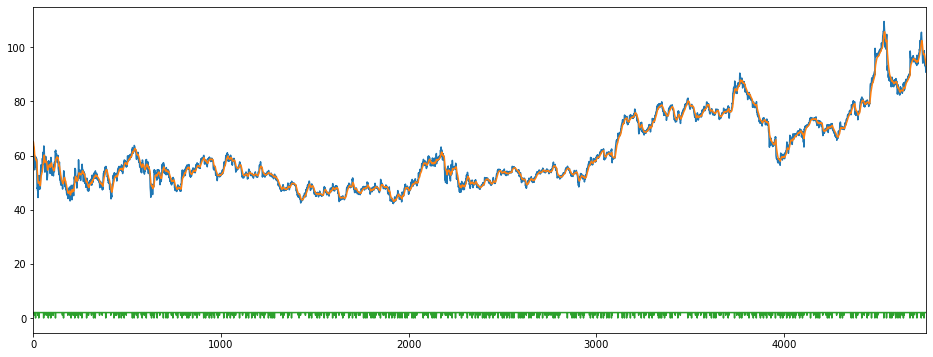

In [121]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [122]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [123]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [124]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [126]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4750, 64, 64, 1)

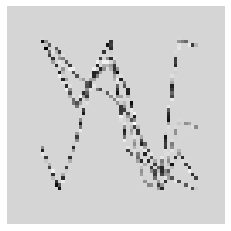

In [127]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [128]:
X = X/255

In [129]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [130]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [131]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [133]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.116104868913857, 1: 7.364341085271318, 2: 0.3671497584541063}
Epoch 1/200
30/30 [==============================] - 2s 65ms/step - loss: 0.2410 - accuracy: 0.3382 - mse: 1.7696 - weighted_accuracy: 0.3466 - weighted_mse: 1.7307 - val_loss: 0.2080 - val_accuracy: 0.0758 - val_mse: 0.9183 - val_weighted_accuracy: 0.0758 - val_weighted_mse: 0.9183
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2083 - accuracy: 0.3642 - mse: 1.1732 - weighted_accuracy: 0.3345 - weighted_mse: 1.1851 - val_loss: 0.1915 - val_accuracy: 0.4821 - val_mse: 1.0105 - val_weighted_accuracy: 0.4821 - val_weighted_mse: 1.0105
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2035 - accuracy: 0.3203 - mse: 1.1970 - weighted_accuracy: 0.3392 - weighted_mse: 1.1772 - val_loss: 0.2068 - val_accuracy: 0.0621 - val_mse: 0.9864 - val_weighted_accuracy: 0.0621 - val_weighted_mse: 0.9864
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2013 - 

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1519 - accuracy: 0.2697 - mse: 1.5147 - weighted_accuracy: 0.6470 - weighted_mse: 1.5373 - val_loss: 0.2029 - val_accuracy: 0.1632 - val_mse: 1.3129 - val_weighted_accuracy: 0.1632 - val_weighted_mse: 1.3129
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1569 - accuracy: 0.2247 - mse: 1.5371 - weighted_accuracy: 0.6231 - weighted_mse: 1.5125 - val_loss: 0.1999 - val_accuracy: 0.1926 - val_mse: 1.2237 - val_weighted_accuracy: 0.1926 - val_weighted_mse: 1.2237
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1558 - accuracy: 0.2671 - mse: 1.4810 - weighted_accuracy: 0.6319 - weighted_mse: 1.4863 - val_loss: 0.1995 - val_accuracy: 0.2158 - val_mse: 1.2790 - val_weighted_accuracy: 0.2158 - val_weighted_mse: 1.2790
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1531 - accuracy: 0.2600 - mse: 1.5554 - weighted_accuracy: 0.6325 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1381 - accuracy: 0.3474 - mse: 1.7222 - weighted_accuracy: 0.6898 - weighted_mse: 1.8076 - val_loss: 0.2037 - val_accuracy: 0.2347 - val_mse: 1.5912 - val_weighted_accuracy: 0.2347 - val_weighted_mse: 1.5912
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1377 - accuracy: 0.3442 - mse: 1.7239 - weighted_accuracy: 0.6908 - weighted_mse: 1.8061 - val_loss: 0.1974 - val_accuracy: 0.2642 - val_mse: 1.4809 - val_weighted_accuracy: 0.2642 - val_weighted_mse: 1.4809
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1347 - accuracy: 0.3579 - mse: 1.7290 - weighted_accuracy: 0.7100 - weighted_mse: 1.8588 - val_loss: 0.1922 - val_accuracy: 0.3147 - val_mse: 1.6390 - val_weighted_accuracy: 0.3147 - val_weighted_mse: 1.6390
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1351 - accuracy: 0.3421 - mse: 1.7789 - weighted_accuracy: 0.7024 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1154 - accuracy: 0.5061 - mse: 2.0243 - weighted_accuracy: 0.7680 - weighted_mse: 2.4500 - val_loss: 0.1624 - val_accuracy: 0.5505 - val_mse: 1.5994 - val_weighted_accuracy: 0.5505 - val_weighted_mse: 1.5994
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1098 - accuracy: 0.5345 - mse: 2.0760 - weighted_accuracy: 0.7838 - weighted_mse: 2.5857 - val_loss: 0.1702 - val_accuracy: 0.5211 - val_mse: 1.7446 - val_weighted_accuracy: 0.5211 - val_weighted_mse: 1.7446
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1119 - accuracy: 0.5182 - mse: 2.0649 - weighted_accuracy: 0.7796 - weighted_mse: 2.6124 - val_loss: 0.1717 - val_accuracy: 0.5221 - val_mse: 1.7133 - val_weighted_accuracy: 0.5221 - val_weighted_mse: 1.7133
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1123 - accuracy: 0.5461 - mse: 2.0581 - weighted_accuracy: 0.7826 - 

Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0907 - accuracy: 0.6939 - mse: 2.6238 - weighted_accuracy: 0.8534 - weighted_mse: 3.6364 - val_loss: 0.1381 - val_accuracy: 0.7084 - val_mse: 2.2487 - val_weighted_accuracy: 0.7084 - val_weighted_mse: 2.2487
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0911 - accuracy: 0.6982 - mse: 2.6416 - weighted_accuracy: 0.8474 - weighted_mse: 3.6587 - val_loss: 0.1309 - val_accuracy: 0.7274 - val_mse: 2.1383 - val_weighted_accuracy: 0.7274 - val_weighted_mse: 2.1383
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0879 - accuracy: 0.6966 - mse: 2.7009 - weighted_accuracy: 0.8470 - weighted_mse: 3.8837 - val_loss: 0.1408 - val_accuracy: 0.6916 - val_mse: 2.2093 - val_weighted_accuracy: 0.6916 - val_weighted_mse: 2.2093
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0929 - accuracy: 0.6950 - mse: 2.6359 - weighted_accuracy: 0.8267 -

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0735 - accuracy: 0.7642 - mse: 3.4064 - weighted_accuracy: 0.8846 - weighted_mse: 5.2255 - val_loss: 0.1247 - val_accuracy: 0.7568 - val_mse: 2.6015 - val_weighted_accuracy: 0.7568 - val_weighted_mse: 2.6015
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0755 - accuracy: 0.7826 - mse: 3.4638 - weighted_accuracy: 0.8805 - weighted_mse: 5.2094 - val_loss: 0.1285 - val_accuracy: 0.7389 - val_mse: 2.4890 - val_weighted_accuracy: 0.7389 - val_weighted_mse: 2.4890
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0723 - accuracy: 0.7903 - mse: 3.2974 - weighted_accuracy: 0.8889 - weighted_mse: 4.9276 - val_loss: 0.1088 - val_accuracy: 0.8116 - val_mse: 2.5996 - val_weighted_accuracy: 0.8116 - val_weighted_mse: 2.5996
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0700 - accuracy: 0.7797 - mse: 3.4104 - weighted_accuracy: 0.8849 - 

In [134]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10917697101831436
Test accuracy: 0.8252631425857544


In [135]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.3957932  -2.5321872   0.5114621 ]
 [-2.334902   -1.8287172   0.4913103 ]
 [-0.9652253  -2.405563    0.15782696]
 ...
 [-1.0510215  -3.0399616   0.27129722]
 [-0.16025484 -4.188526   -0.43898645]
 [-2.1555097  -1.7473738   0.5483592 ]]


Counter({2: 855, 0: 61, 1: 34})

In [136]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 44, 1: 43})

In [137]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 950
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 40
actual holds but predicted buy: 30
actual holds but predicted sell: 57
actual predicted holds: 776
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 89.9188876013905%
actual buys: 43
actual sells: 44
actual holds: 863


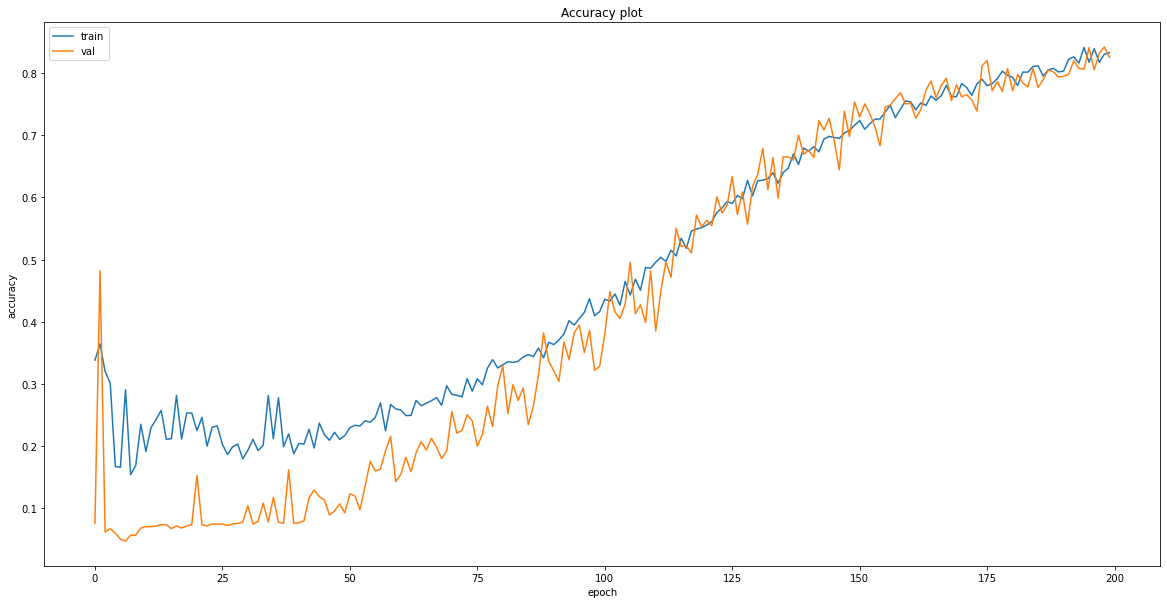

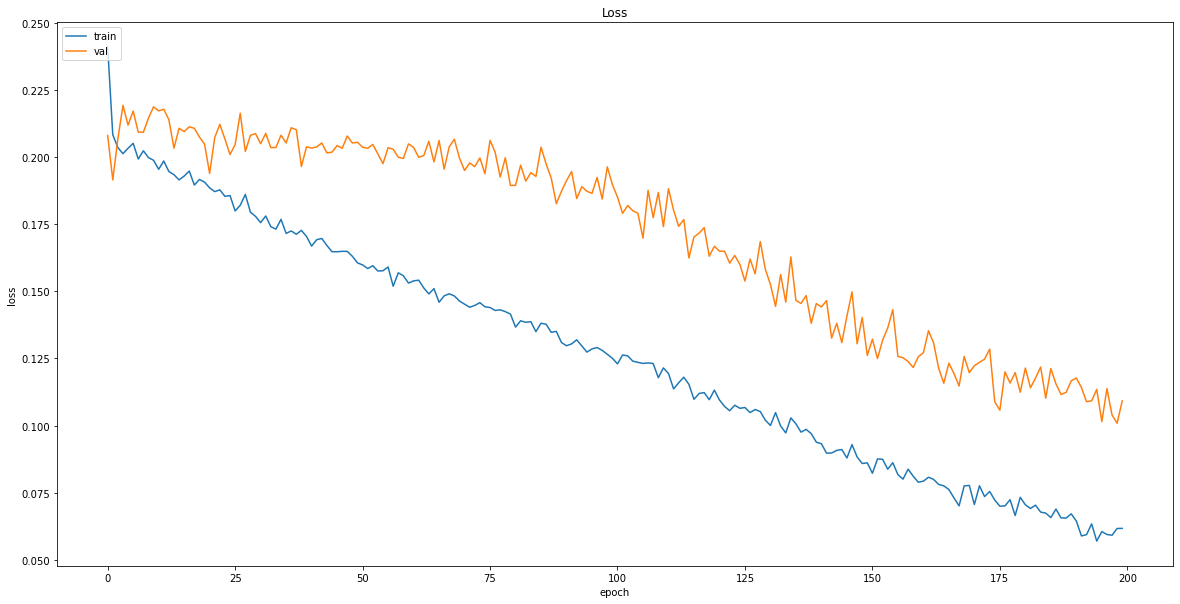

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [139]:
# Save model
model.save("models/{}".format('wmt_image_cnn_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/wmt_image_cnn_buy_hold_sell_10.model\assets


### Test Performance

#### Non-Recession

In [140]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-29,97.059998,96.626808,-36.757664,50249200.0,2.0
2019-01-30,96.709999,96.639606,-42.375621,44995800.0,2.0
2019-01-31,94.800003,96.356591,-73.033684,33146500.0,2.0
2019-02-01,95.830002,96.275577,-69.155190,47869500.0,1.0
2019-02-04,93.860001,95.903950,-87.980765,35277600.0,2.0


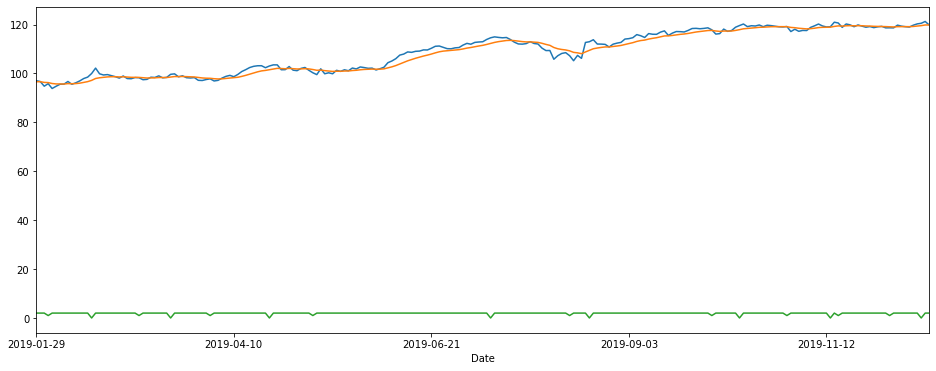

In [141]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [142]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [144]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [145]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [146]:
model = tf.keras.models.load_model("models/wmt_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1052 - accuracy: 0.8119 - mean_squared_error: 3.1960 - weighted_accuracy: 0.8119 - weighted_mean_squared_error: 3.1960
Test loss: 0.10515997558832169
Test accuracy: 0.8119266033172607


In [147]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 193, 0: 19, 1: 6})

In [148]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [149]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,0,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


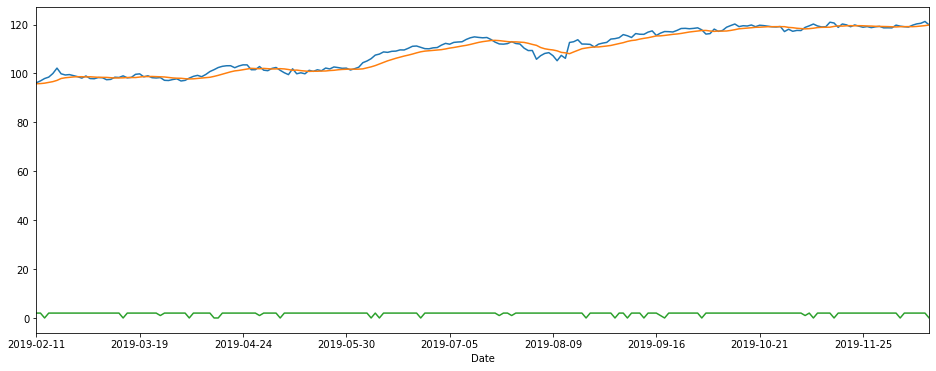

In [150]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

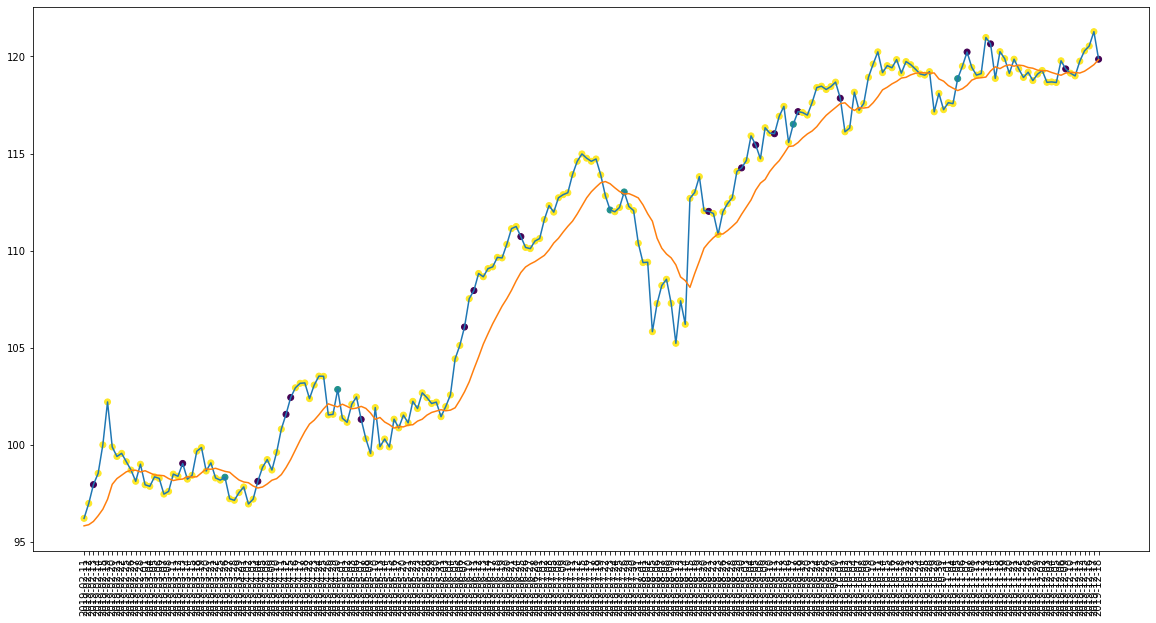

In [151]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

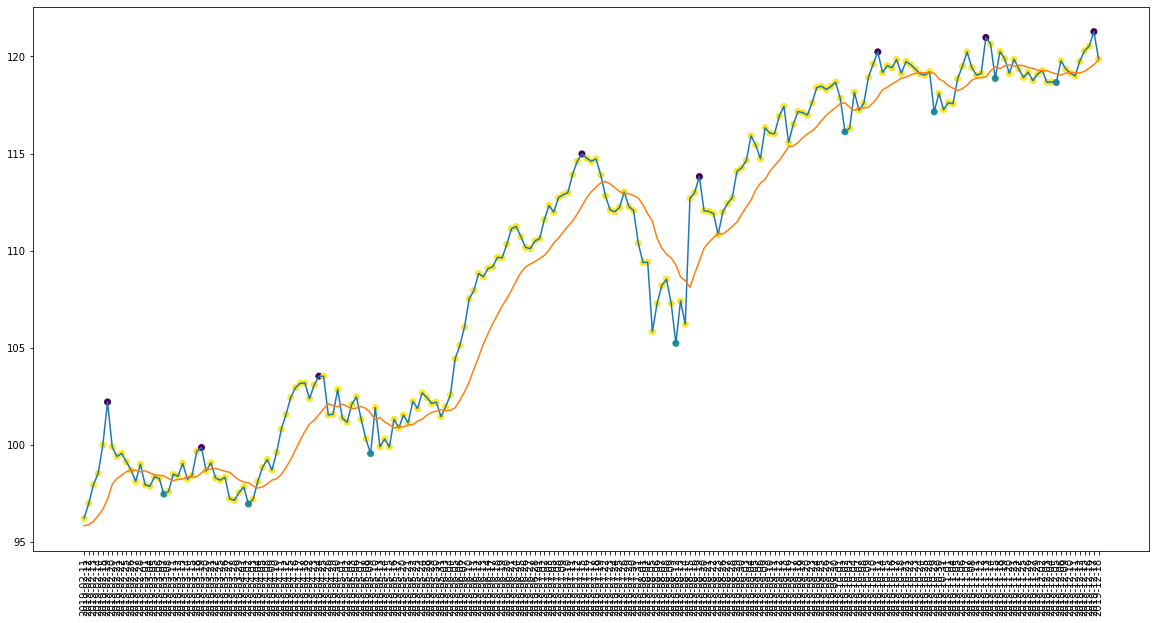

In [152]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [153]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 6
actual holds but predicted sell: 19
actual predicted holds: 177
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 87.62376237623762%
actual buys: 8
actual sells: 8
actual holds: 202


In [154]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 42.10526315789474%
Percentage holds correct: 84.89583333333333%


In [155]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.31999969482422
Shares owned at the moment: 101
Cash capital at the moment: $42.371650907516596


Price increase from previously bought: 7.576416571062761%
Share price: $106.05999755859376
Shares owned at the moment: 0
Cash capital at the moment: $10724.973240003588


Share price: $112.08999633789062
Shares owned at the moment: 95
Cash capital at the moment: $47.14007636070528


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10072.394572448733


Share price: $116.51000213623048
Shares owned at the moment: 86
Cash capital at the moment: $24.97977322769293




Capital at the end of test period: $10304.592935573579
profit gained: 3.045929355735789%


In [156]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### Recession

In [157]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-29,116.599998,116.083829,-16.417993,-9158300.0,2.0
2020-01-30,115.889999,116.054009,-31.556558,-12933800.0,2.0
2020-01-31,116.580002,116.134931,-16.308909,-8352300.0,2.0
2020-02-03,114.489998,115.881864,-59.234312,-16128100.0,1.0
2020-02-04,114.269997,115.633884,-64.189291,-20480000.0,2.0


In [158]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [160]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [161]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [162]:
model = tf.keras.models.load_model("models/wmt_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1003 - accuracy: 0.8174 - mean_squared_error: 3.2982 - weighted_accuracy: 0.8174 - weighted_mean_squared_error: 3.2982
Test loss: 0.10027417540550232
Test accuracy: 0.8173515796661377


In [163]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 191, 0: 16, 1: 12})

In [164]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [165]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


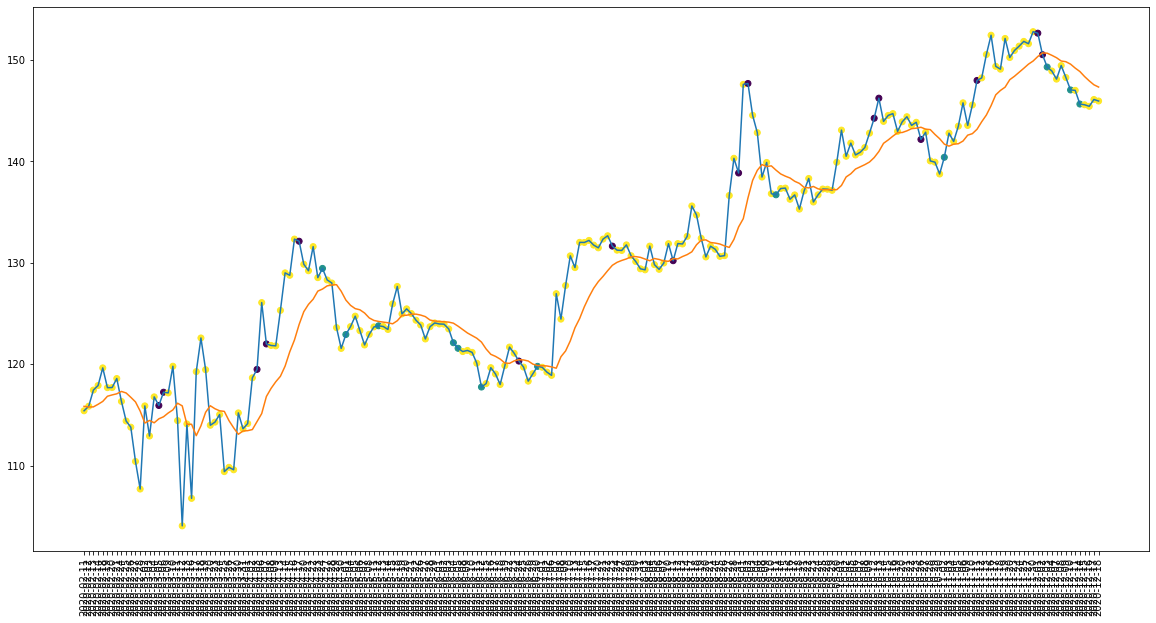

In [166]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

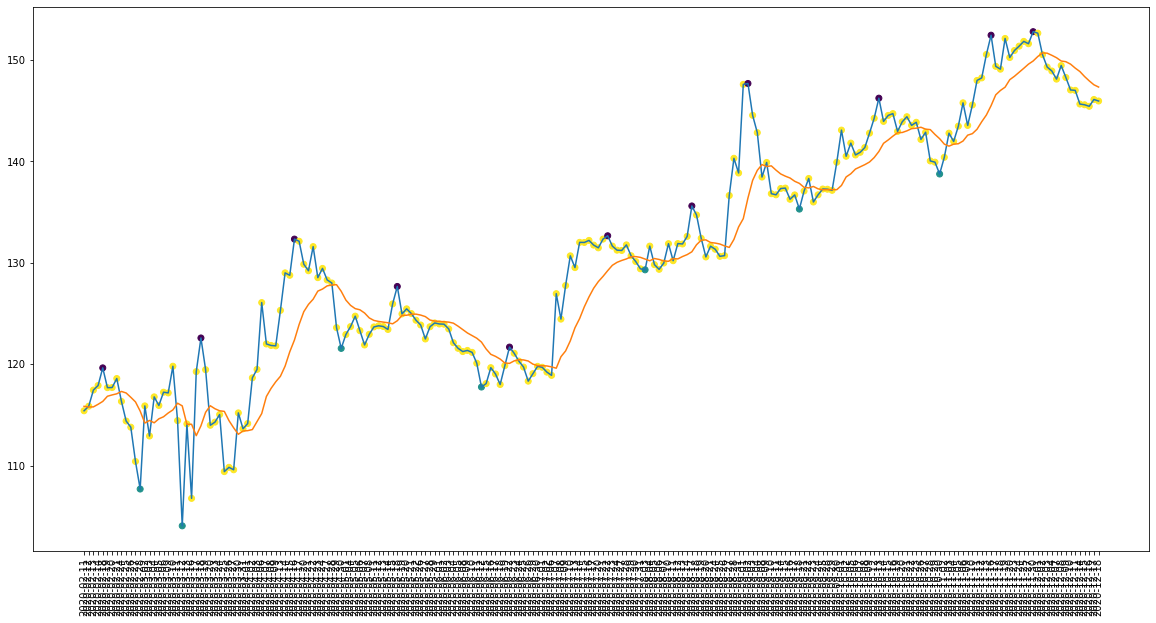

In [167]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [168]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 11
actual holds but predicted sell: 14
actual predicted holds: 176
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 87.56218905472637%
actual buys: 7
actual sells: 11
actual holds: 201


In [169]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 50.0%
Percentage sells correct: 50.0%
Percentage holds correct: 84.73684210526316%


In [170]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $129.44000244140622
Shares owned at the moment: 77
Cash capital at the moment: $5.710891494753014


Stop Loss Activated!

Share price: $123.5999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9496.738474325182


Share price: $122.91999816894531
Shares owned at the moment: 77
Cash capital at the moment: $5.8703057041184366


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $9046.918696666717


Share price: $117.73999786376952
Shares owned at the moment: 76
Cash capital at the moment: $74.07119946670537


Price increase from previously bought: 11.499052633350137%
Share price: $131.63999938964844
Shares owned at the moment: 0
Cash capital at the moment: $10051.198393207549


Share price: $136.69999694824222
Shares owned at the moment: 73
Cash capital at the moment: $44.65609159850828


Price increase from previously bought: 5.23365297028473%
Share price: $144.25
Shares owned at the moment: 0


In [171]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

In [172]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


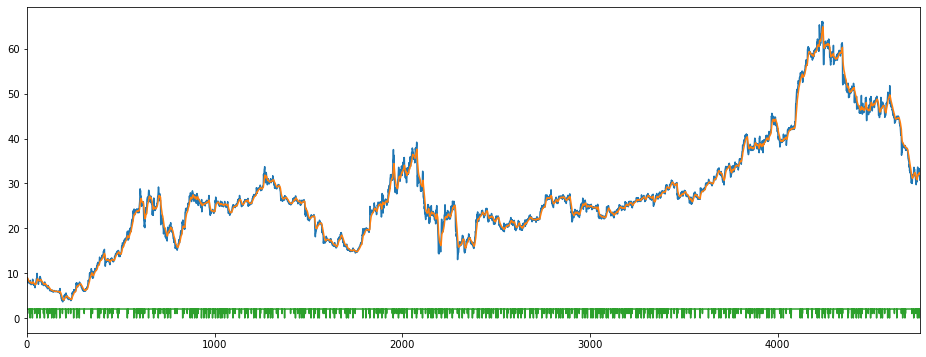

In [173]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [174]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [175]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1

In [176]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [178]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4750, 64, 64, 1)

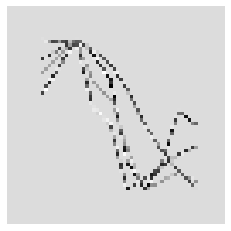

In [179]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [180]:
X = X/255

In [181]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [182]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [183]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [184]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [185]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.2796934865900385, 1: 7.1563088512241055, 2: 0.3672562095293322}
Epoch 1/200
30/30 [==============================] - 2s 63ms/step - loss: 0.2342 - accuracy: 0.3966 - mse: 1.6321 - weighted_accuracy: 0.3494 - weighted_mse: 1.6256 - val_loss: 0.1957 - val_accuracy: 0.3221 - val_mse: 1.0187 - val_weighted_accuracy: 0.3221 - val_weighted_mse: 1.0187
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2074 - accuracy: 0.4237 - mse: 1.1351 - weighted_accuracy: 0.3266 - weighted_mse: 1.1524 - val_loss: 0.2021 - val_accuracy: 0.0526 - val_mse: 1.0056 - val_weighted_accuracy: 0.0526 - val_weighted_mse: 1.0056
Epoch 3/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2051 - accuracy: 0.4103 - mse: 1.1793 - weighted_accuracy: 0.3215 - weighted_mse: 1.1822 - val_loss: 0.2016 - val_accuracy: 0.0579 - val_mse: 0.9518 - val_weighted_accuracy: 0.0579 - val_weighted_mse: 0.9518
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.201

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1685 - accuracy: 0.2589 - mse: 1.3916 - weighted_accuracy: 0.5763 - weighted_mse: 1.3527 - val_loss: 0.1968 - val_accuracy: 0.1411 - val_mse: 1.1547 - val_weighted_accuracy: 0.1411 - val_weighted_mse: 1.1547
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1690 - accuracy: 0.2347 - mse: 1.3892 - weighted_accuracy: 0.5690 - weighted_mse: 1.3422 - val_loss: 0.1878 - val_accuracy: 0.2811 - val_mse: 1.1919 - val_weighted_accuracy: 0.2811 - val_weighted_mse: 1.1919
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1724 - accuracy: 0.2924 - mse: 1.3760 - weighted_accuracy: 0.5412 - weighted_mse: 1.3071 - val_loss: 0.1844 - val_accuracy: 0.3168 - val_mse: 1.1675 - val_weighted_accuracy: 0.3168 - val_weighted_mse: 1.1675
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1671 - accuracy: 0.2574 - mse: 1.3822 - weighted_accuracy: 0.5702 - we

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1510 - accuracy: 0.3771 - mse: 1.4878 - weighted_accuracy: 0.6392 - weighted_mse: 1.4617 - val_loss: 0.1923 - val_accuracy: 0.2779 - val_mse: 1.2914 - val_weighted_accuracy: 0.2779 - val_weighted_mse: 1.2914
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1529 - accuracy: 0.3774 - mse: 1.4431 - weighted_accuracy: 0.6229 - weighted_mse: 1.4330 - val_loss: 0.1911 - val_accuracy: 0.2758 - val_mse: 1.3325 - val_weighted_accuracy: 0.2758 - val_weighted_mse: 1.3325
Epoch 88/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1522 - accuracy: 0.3655 - mse: 1.5185 - weighted_accuracy: 0.6349 - weighted_mse: 1.4973 - val_loss: 0.1960 - val_accuracy: 0.2589 - val_mse: 1.3912 - val_weighted_accuracy: 0.2589 - val_weighted_mse: 1.3912
Epoch 89/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1493 - accuracy: 0.3647 - mse: 1.5403 - weighted_accuracy: 0.6601 - w

Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1323 - accuracy: 0.4908 - mse: 1.6213 - weighted_accuracy: 0.7241 - weighted_mse: 1.7064 - val_loss: 0.1681 - val_accuracy: 0.5158 - val_mse: 1.4420 - val_weighted_accuracy: 0.5158 - val_weighted_mse: 1.4420
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1255 - accuracy: 0.5079 - mse: 1.6893 - weighted_accuracy: 0.7485 - weighted_mse: 1.8407 - val_loss: 0.1677 - val_accuracy: 0.5168 - val_mse: 1.4877 - val_weighted_accuracy: 0.5168 - val_weighted_mse: 1.4877
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1256 - accuracy: 0.4997 - mse: 1.7319 - weighted_accuracy: 0.7493 - weighted_mse: 1.9090 - val_loss: 0.1772 - val_accuracy: 0.4600 - val_mse: 1.4687 - val_weighted_accuracy: 0.4600 - val_weighted_mse: 1.4687
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1279 - accuracy: 0.5126 - mse: 1.6756 - weighted_accuracy: 0.7393

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1069 - accuracy: 0.6232 - mse: 1.9301 - weighted_accuracy: 0.8145 - weighted_mse: 2.2776 - val_loss: 0.1408 - val_accuracy: 0.6800 - val_mse: 1.6519 - val_weighted_accuracy: 0.6800 - val_weighted_mse: 1.6519
Epoch 145/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1074 - accuracy: 0.6039 - mse: 1.9417 - weighted_accuracy: 0.8074 - weighted_mse: 2.2708 - val_loss: 0.1618 - val_accuracy: 0.5747 - val_mse: 1.6556 - val_weighted_accuracy: 0.5747 - val_weighted_mse: 1.6556
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1052 - accuracy: 0.6255 - mse: 1.9184 - weighted_accuracy: 0.8207 - weighted_mse: 2.3056 - val_loss: 0.1521 - val_accuracy: 0.6253 - val_mse: 1.7118 - val_weighted_accuracy: 0.6253 - val_weighted_mse: 1.7118
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1051 - accuracy: 0.6337 - mse: 1.9518 - weighted_accuracy: 0.8255 -

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0887 - accuracy: 0.6874 - mse: 2.3403 - weighted_accuracy: 0.8508 - weighted_mse: 2.9308 - val_loss: 0.1496 - val_accuracy: 0.6484 - val_mse: 1.8513 - val_weighted_accuracy: 0.6484 - val_weighted_mse: 1.8513
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.0908 - accuracy: 0.6808 - mse: 2.3009 - weighted_accuracy: 0.8447 - weighted_mse: 2.9113 - val_loss: 0.1398 - val_accuracy: 0.6916 - val_mse: 1.9589 - val_weighted_accuracy: 0.6916 - val_weighted_mse: 1.9589
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0883 - accuracy: 0.6887 - mse: 2.3308 - weighted_accuracy: 0.8530 - weighted_mse: 2.9888 - val_loss: 0.1267 - val_accuracy: 0.7400 - val_mse: 1.8288 - val_weighted_accuracy: 0.7400 - val_weighted_mse: 1.8288
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0867 - accuracy: 0.6861 - mse: 2.3125 - weighted_accuracy: 0.8539 -

In [186]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12497326731681824
Test accuracy: 0.75789475440979


In [187]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.5604626  -1.0279795   0.04596567]
 [-1.3707212  -1.2522804   0.30009544]
 [-0.40790388 -2.164661   -0.307608  ]
 ...
 [-0.01178125 -2.5953555  -0.6424432 ]
 [-1.7663795  -0.51424694 -0.35789728]
 [-0.30941433 -1.3669821  -0.55712223]]


Counter({2: 770, 0: 116, 1: 64})

In [188]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 43, 1: 44})

In [189]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 950
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 36
actual sells but predicted buy: 3
actual predicted sells: 10
actual sells but predicted hold: 30
actual holds but predicted buy: 55
actual holds but predicted sell: 104
actual predicted holds: 704
Percentage buys correct: 13.636363636363637%
Percentage sells correct: 23.25581395348837%
Percentage holds correct: 81.57589803012746%
actual buys: 44
actual sells: 43
actual holds: 863


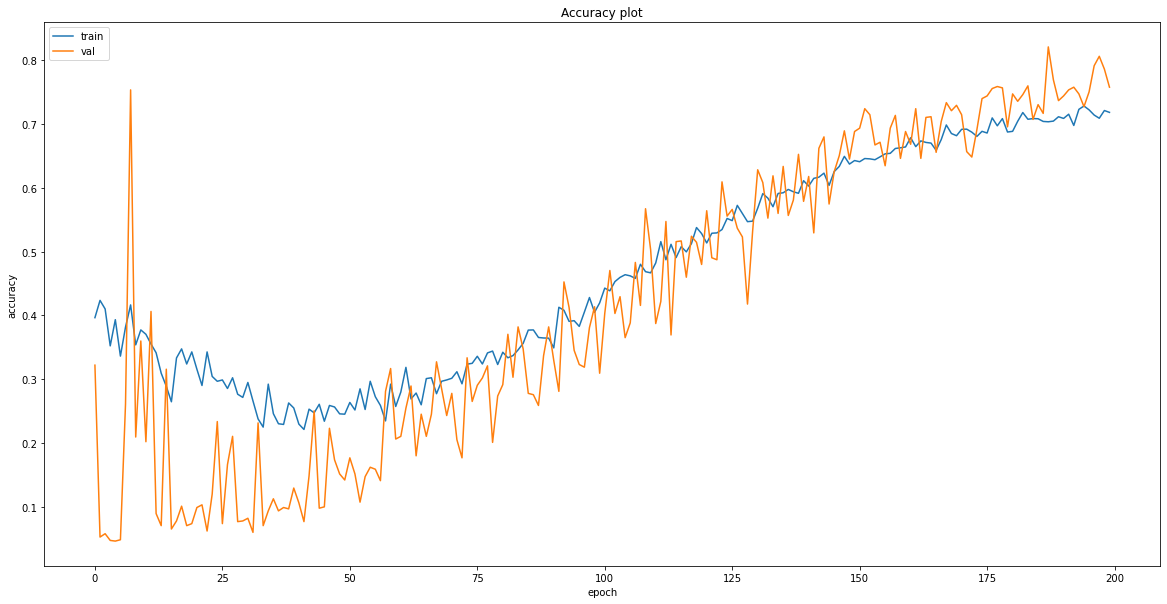

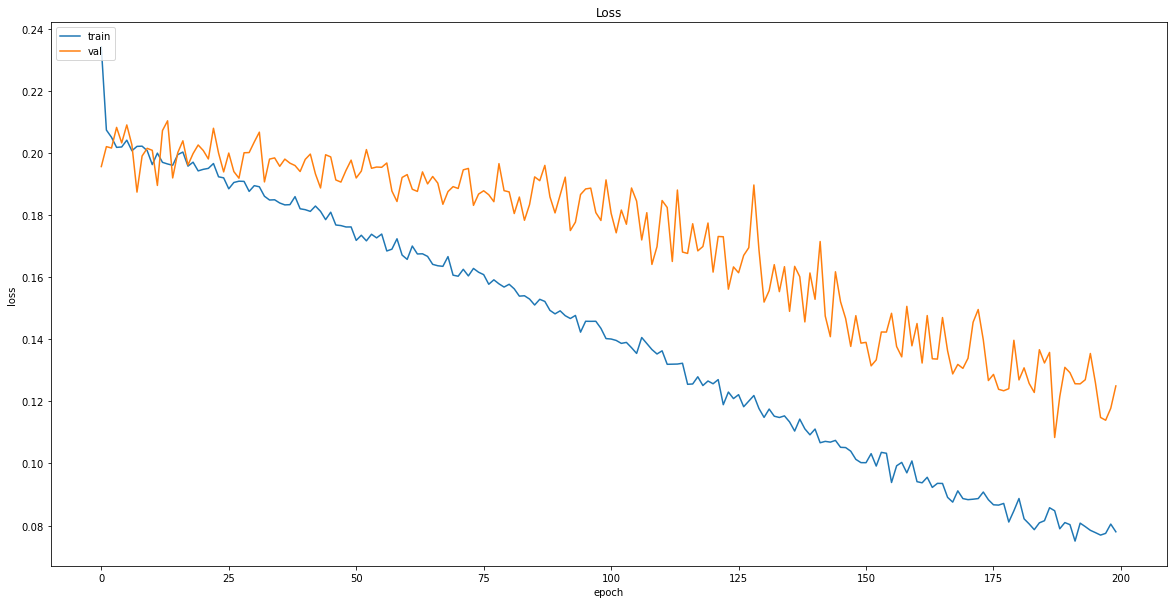

In [190]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [191]:
# Save model
model.save("models/{}".format('FDP_image_cnn_buy_hold_sell_10.model'))

INFO:tensorflow:Assets written to: models/FDP_image_cnn_buy_hold_sell_10.model\assets


### Test Performance

### non-recession

In [192]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-29,30.889999,30.367178,-27.586264,1834800.0,2.0
2019-01-30,31.139999,30.486073,-13.218461,1920100.0,2.0
2019-01-31,31.540001,30.648216,-15.486657,2046500.0,2.0
2019-02-01,31.980000,30.853106,-5.241975,2142700.0,2.0
2019-02-04,32.009998,31.031089,-10.188698,2253700.0,2.0


In [193]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [194]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [195]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [196]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [197]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.7294 - mean_squared_error: 2.1576 - weighted_accuracy: 0.7294 - weighted_mean_squared_error: 2.1576
Test loss: 0.13085158169269562
Test accuracy: 0.7293577790260315


In [198]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 177, 0: 25, 1: 16})

In [199]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [200]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,2,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,2,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,2,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,0,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


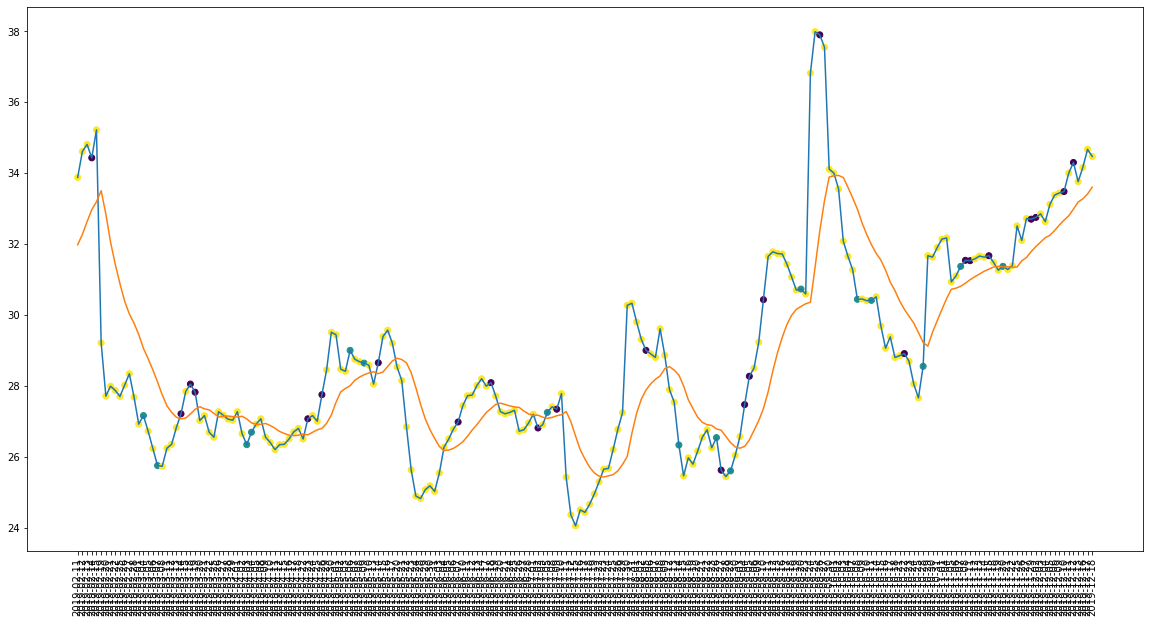

In [201]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

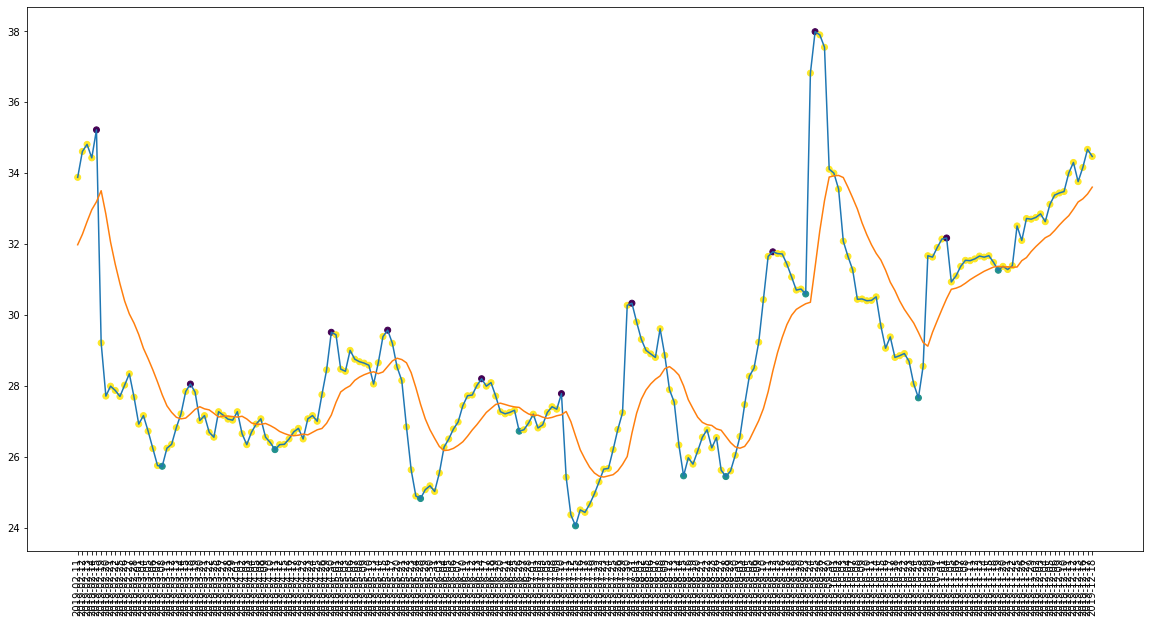

In [202]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [203]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 16
actual holds but predicted sell: 24
actual predicted holds: 158
Percentage buys correct: 0.0%
Percentage sells correct: 10.0%
Percentage holds correct: 79.79797979797979%
actual buys: 10
actual sells: 10
actual holds: 198


In [204]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 56.25%
Percentage sells correct: 48.0%
Percentage holds correct: 81.81818181818181%


In [205]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.15999984741211
Shares owned at the moment: 367
Cash capital at the moment: $4.868826153755435


Stop Loss Activated!

Share price: $26.229999542236328
Shares owned at the moment: 0
Cash capital at the moment: $9604.806031116486


Share price: $25.75
Shares owned at the moment: 371
Cash capital at the moment: $25.284593616486745


Price increase from previously bought: 5.380104070980152%
Share price: $27.209999084472656
Shares owned at the moment: 0
Cash capital at the moment: $10092.433252389908


Share price: $26.34000015258789
Shares owned at the moment: 382
Cash capital at the moment: $2.883023941039937


Price increase from previously bought: 5.064148153110337%
Share price: $27.75
Shares owned at the moment: 0
Cash capital at the moment: $10574.23164894104


Share price: $29.0
Shares owned at the moment: 363
Cash capital at the moment: $18.28239894104081


Stop Loss Activated!

Share price: $28.04999923706055
Shares owned at the moment: 0
Cash capital at the moment

In [206]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [207]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[5:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-29,32.560001,33.556203,-73.873848,-176200.0,2.0
2020-01-30,31.620001,33.258326,-99.415191,-270900.0,2.0
2020-01-31,31.770000,33.029353,-86.898401,-180300.0,2.0
2020-02-03,31.379999,32.775606,-90.547286,-321500.0,2.0
2020-02-04,31.900000,32.640897,-77.611952,-129800.0,1.0


In [208]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_10_price = []
data_10_willr = []
data_10_ema = []
data_10_obv = []
count = 0

for i in df.values:
    if count == 9:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_10_price_arr = min_max_scaler.fit_transform(data_10_price)
        data_10_ema_arr = min_max_scaler.fit_transform(data_10_ema)
        data_10_willr_arr = min_max_scaler.fit_transform(data_10_willr)
        data_10_obv_arr = min_max_scaler.fit_transform(data_10_obv)
        price_data.append(data_10_price_arr)
        willr_data.append(data_10_willr_arr)
        ema_data.append(data_10_ema_arr)
        obv_data.append(data_10_obv_arr)
        labels.append(i[-1])
        data_10_price = data_10_price[1:]
        data_10_willr = data_10_willr[1:]
        data_10_obv = data_10_obv[1:]
        data_10_ema = data_10_ema[1:]
    
    else:
        data_10_price.append([i[0]])
        data_10_ema.append([i[1]])
        data_10_willr.append([i[2]])
        data_10_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [209]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [210]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [211]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [212]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_10.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1238 - accuracy: 0.7397 - mean_squared_error: 2.1180 - weighted_accuracy: 0.7397 - weighted_mean_squared_error: 2.1180
Test loss: 0.12377486377954483
Test accuracy: 0.7397260069847107


In [213]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 23, 2: 177, 1: 19})

In [214]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [215]:
df = df.iloc[9:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,0,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,2,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,0,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


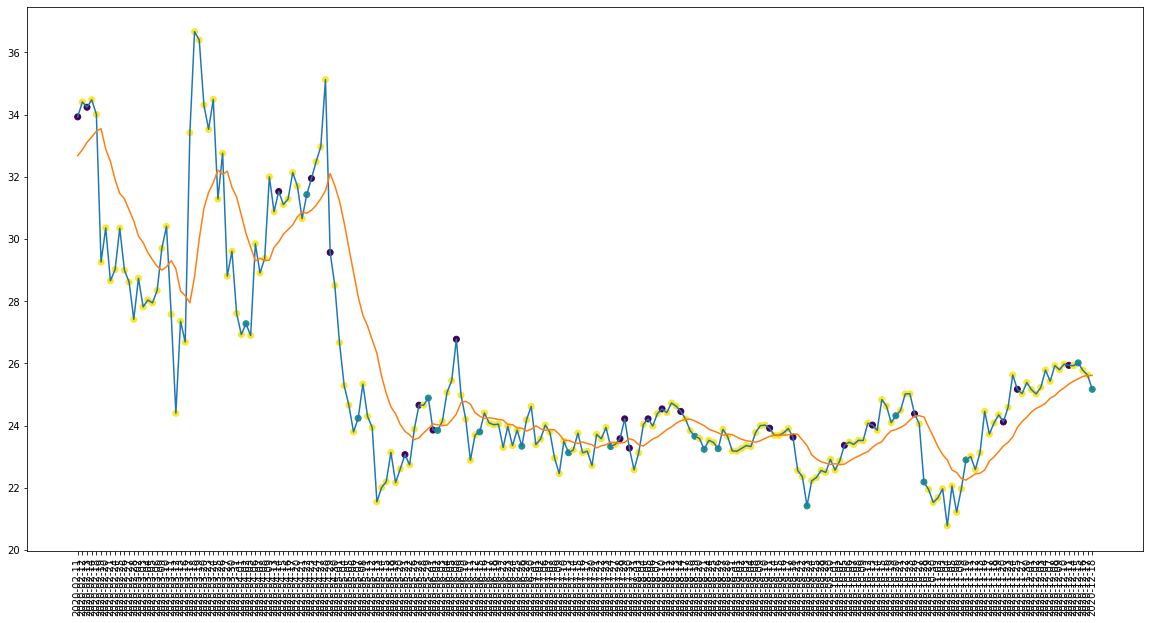

In [216]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

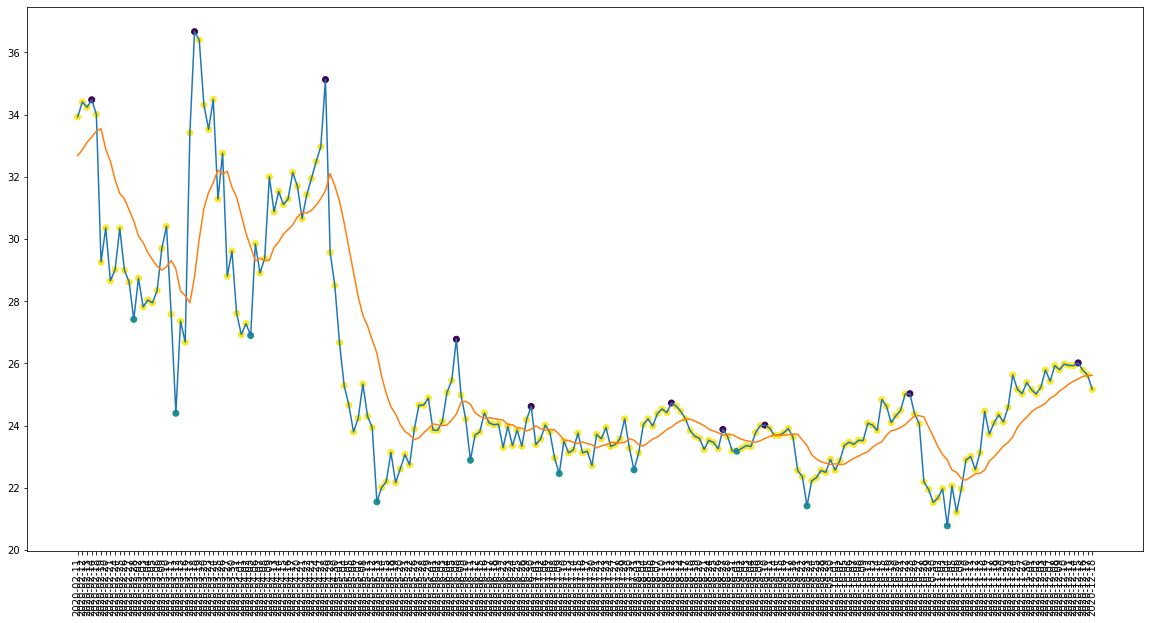

In [217]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [218]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 17
actual holds but predicted sell: 22
actual predicted holds: 160
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 80.40201005025126%
actual buys: 10
actual sells: 10
actual holds: 199


In [219]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 72.22222222222223%
Percentage sells correct: 56.52173913043478%
Percentage holds correct: 82.48587570621469%


In [220]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.28000068664551
Shares owned at the moment: 365
Cash capital at the moment: $15.417448685167983


Price increase from previously bought: 15.262207423084572%
Share price: $31.53000068664551
Shares owned at the moment: 0
Cash capital at the moment: $11492.21946112156


Share price: $31.43000030517578
Shares owned at the moment: 364
Cash capital at the moment: $20.23791973209518


Stop Loss Activated!

Share price: $29.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10754.118238953592


Share price: $24.239999771118164
Shares owned at the moment: 442
Cash capital at the moment: $10.574620397568651


Stop Loss Activated!

Share price: $21.549999237060547
Shares owned at the moment: 0
Cash capital at the moment: $9509.480259105683


Share price: $24.88999938964844
Shares owned at the moment: 381
Cash capital at the moment: $0.3119947891227639


Stop Loss Activated!

Share price: $23.86000061035156
Shares owned at the moment: 0
Cash capital at the mo

In [221]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
